Group number: **6**

Student 1 name, student 1 number: **Aumkar Lele, s4743962**  
Student 2 name, student 2 number: **Djamari Oetringer, s4464559**  
Student 3 name, student 3 number: **Daphne Lenders, s4433556**  

**SOW-MKI49: Neural Information Processing Systems**

**Assignment 5: Neural Decoding**

**Total points: 100**

**Author: Umut**

In this assignment, you will implement a neural decoder for reconstructing perceived stimuli from brain responses. We will be using the dataset that was previously used in a number of papers. These papers along with additional lecture notes on neural decoding can be found in Brightspace. You can refer them for more details on the dataset and/or the method.

The dataset contains fMRI data acquired from the early visual cortex of one subject as the subject was presented with 100 grayscale images of handwritten sixes and nines (50 sixes and 50 nines). The fMRI data has been realigned and slice time corrected. Furthermore, stimulus specific response amplitudes have been estimated with a general linear model.

Let's first familiarize ourselves with the dataset. It contains a number of variables:

* **X** -> This is a 100 x 784 matrix. The ith row contains the pixel values of the stimulus that was presented in the ith trial of the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

* **Y** -> This is a 100 x 3092 matrix. The ith row contains the voxel values of the responses that were measured in the ith trial of the experiment.

* **X_prior** -> This is a 2000 x 784 matrix. Each row contains the pixel values of a different stimulus, which was not used in the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

Note: In the remainder of this document, we will use **x** for referring to a 784 x 1 stimulus vector and **y** for referring to a 3092 x 1 response vector.

## Task 1 (10 points)

* Load the dataset.
* Visualize some of the stimuli.
* Normalize X and Y to have zero mean and unit variance. Tip: Recall that normalization means subtracting the mean of each pixel/voxel from itself and dividing it by its standard deviation. You can use zscore function.
* Split X and Y in two parts called X_training and X_test, and Y_training and Y_test. The training set should contain 80 stimulus-response pairs (40 pairs for sixes and 40 pairs for nines). The test set should contain 20 stimulus-response pairs (10 pairs for sixes and 10 pairs for nines).

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.dataset import concat_examples
from chainer.datasets import TupleDataset
from chainer import serializers

C:\Users\Djamari\Anaconda2\envs\py3k6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
### Load the dataset
data = sio.loadmat('69dataset2.mat')

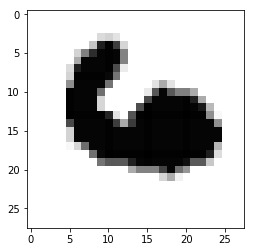

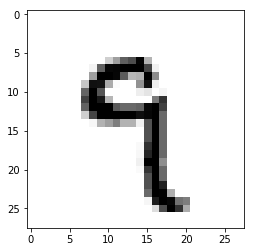

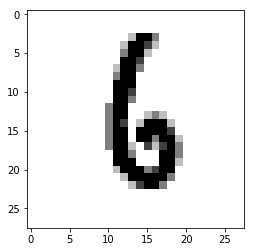

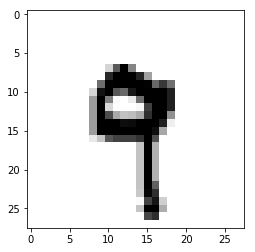

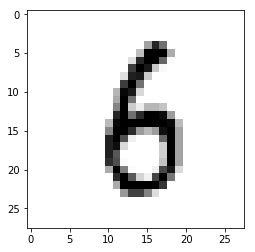

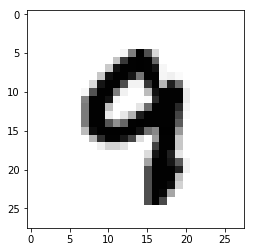

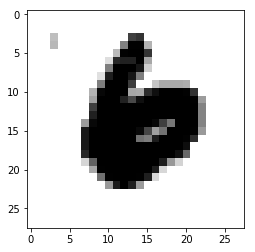

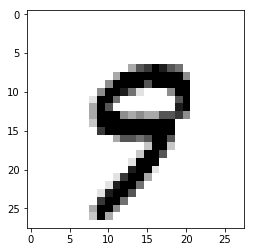

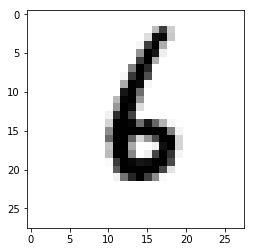

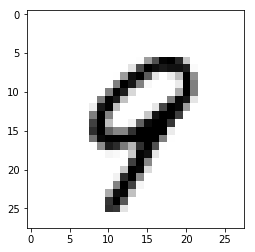

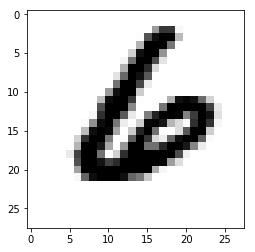

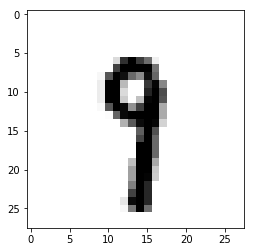

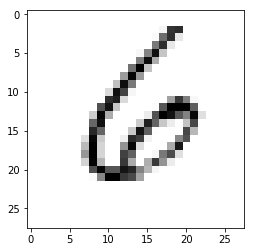

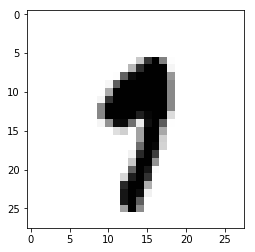

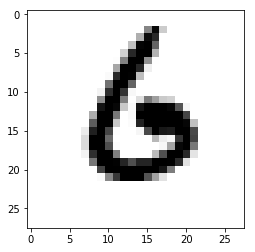

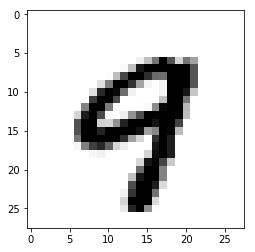

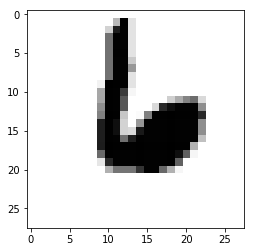

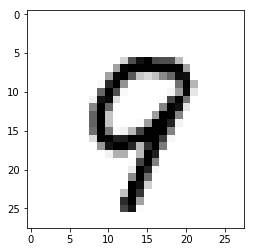

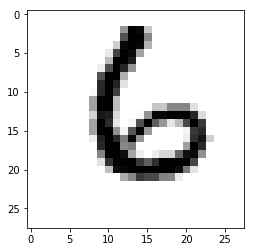

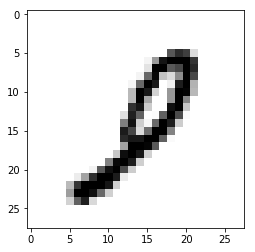

In [3]:
### Visualize some of the stimuli
for i in range(10):
    imgplot = plt.imshow(data['X'][i,:].reshape(28,28).transpose(), cmap = cm.binary)
    plt.show()
    imgplot = plt.imshow(data['X'][i+50,:].reshape(28,28).transpose(), cmap = cm.binary)
    plt.show()

C:\Users\Djamari\Anaconda2\envs\py3k6\lib\site-packages\scipy\stats\stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


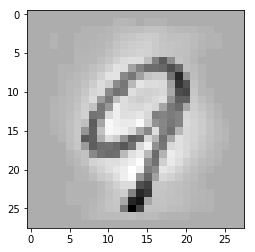

In [4]:
### Normalize X and Y to have zero mean and unit variance. 

X = data['X']
Y = data['Y']
X_prior = data['X_prior']

X_norm = zscore(X, axis = 0)
Y_norm = zscore(Y, axis = 0)
X_prior_norm = zscore(X_prior, axis = 0)

# Remove NaNs
where_are_NaNs = np.isnan(X_norm)
X_norm[where_are_NaNs] = 0
where_are_NaNs = np.isnan(Y_norm)
Y_norm[where_are_NaNs] = 0
where_are_NaNs = np.isnan(X_prior_norm)
X_prior_norm[where_are_NaNs] = 0
X_prior = X_prior_norm

# Plot an example as a check
imgplot = plt.imshow(X_norm[60,:].reshape(28,28).transpose(), cmap = cm.binary)
plt.show()

        

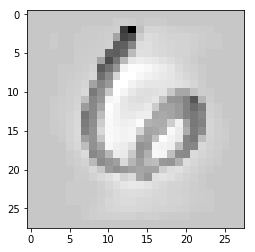

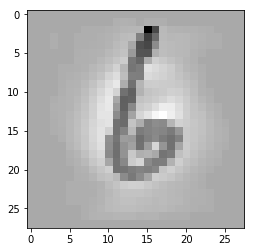

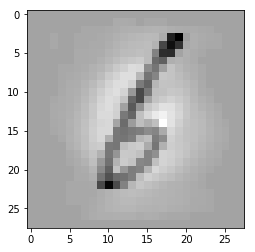

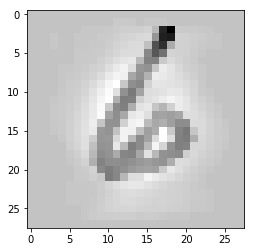

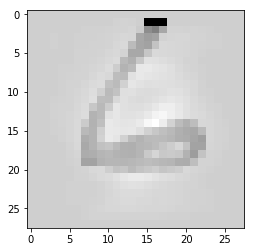

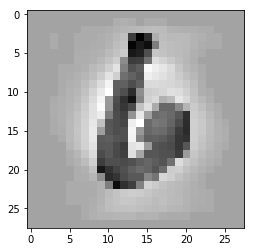

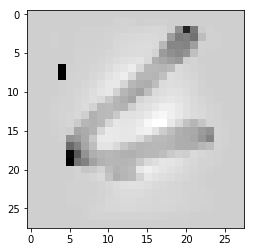

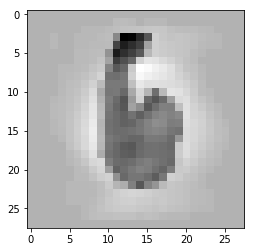

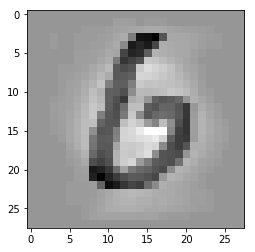

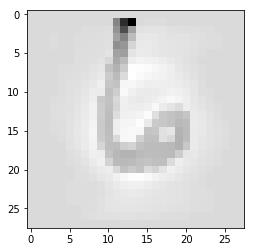

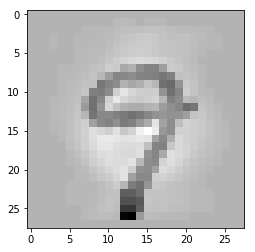

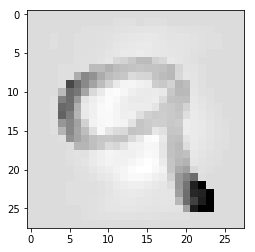

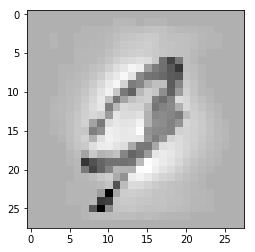

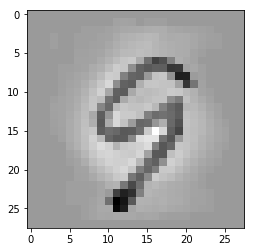

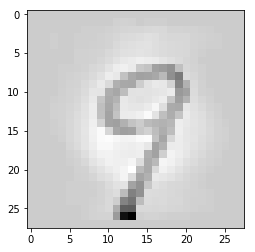

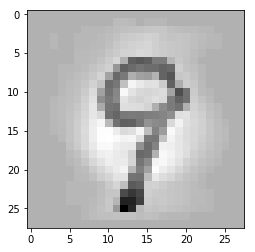

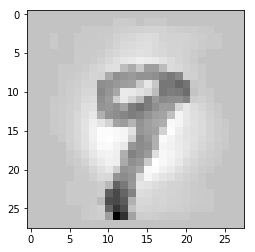

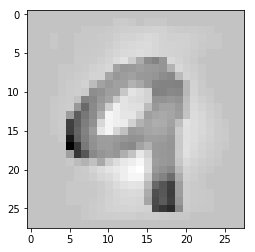

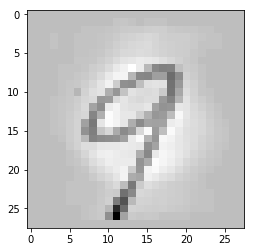

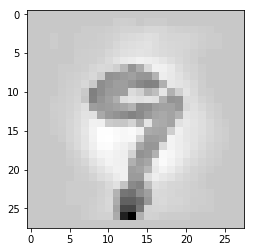

In [5]:
### Split X and Y in two parts 

X_norm_sixes = X_norm[0:50, :]
Y_norm_sixes = Y_norm[0:50, :]
X_norm_nines = X_norm[50:100, :]
Y_norm_nines = Y_norm[50:100, :]

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X_norm_sixes, Y_norm_sixes, test_size =  0.2, random_state = 42) 
X_train9, X_test9, Y_train9, Y_test9 = train_test_split(X_norm_nines, Y_norm_nines, test_size =  0.2, random_state = 42) 

X_training = np.concatenate((X_train6, X_train9))
X_test = np.concatenate((X_test6, X_test9))
Y_training = np.concatenate((Y_train6, Y_train9))
Y_test = np.concatenate((Y_test6, Y_test9))

for i in range(20):
    imgplot = plt.imshow(X_test[i,:].reshape(28,28).transpose(), cmap = cm.binary)
    plt.show()




### Our goal is to solve the problem of reconstructing **x** from **y**. One possible approach to solve this problem is to use a *discriminative* model. Discriminative models predict **x** as a function of **y**. That is:

**x** = f(**y**)

We will assume that f is a linear function. That is:

**x** = **B'** **y**

f can be seen as a very simple linear neural network comprising one layer of weights (i.e., **B**). We can estimate **B** in close form with ridge regression. That is:

**B** = inv(**Y**\_training' **Y**\_training + lambda **I**) **Y**\_training' **X**\_training

where lambda is the regularization coefficient, **I** is the *q* x *q* identity matrix, and *q* is the number of voxels. Note that we can safely ignore the intercept since we normalized our data to have zero mean and unit variance.

## Task 2  (15 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross validation to estimate lambda. For simplicity, you can assume that lambda = 10 ^ -6.
* Reconstruct **x** from **y** in the test set.
* Visualize the reconstructions.

In [6]:
### Estimage B on the training set

# Initialize
lambda_ = 1e-6
numVoxels = Y_training.shape[1]
I =  np.identity(numVoxels)

# Compute B
B = np.linalg.inv(Y_training.T @ Y_training + lambda_ * I) @ Y_training.T @ X_training

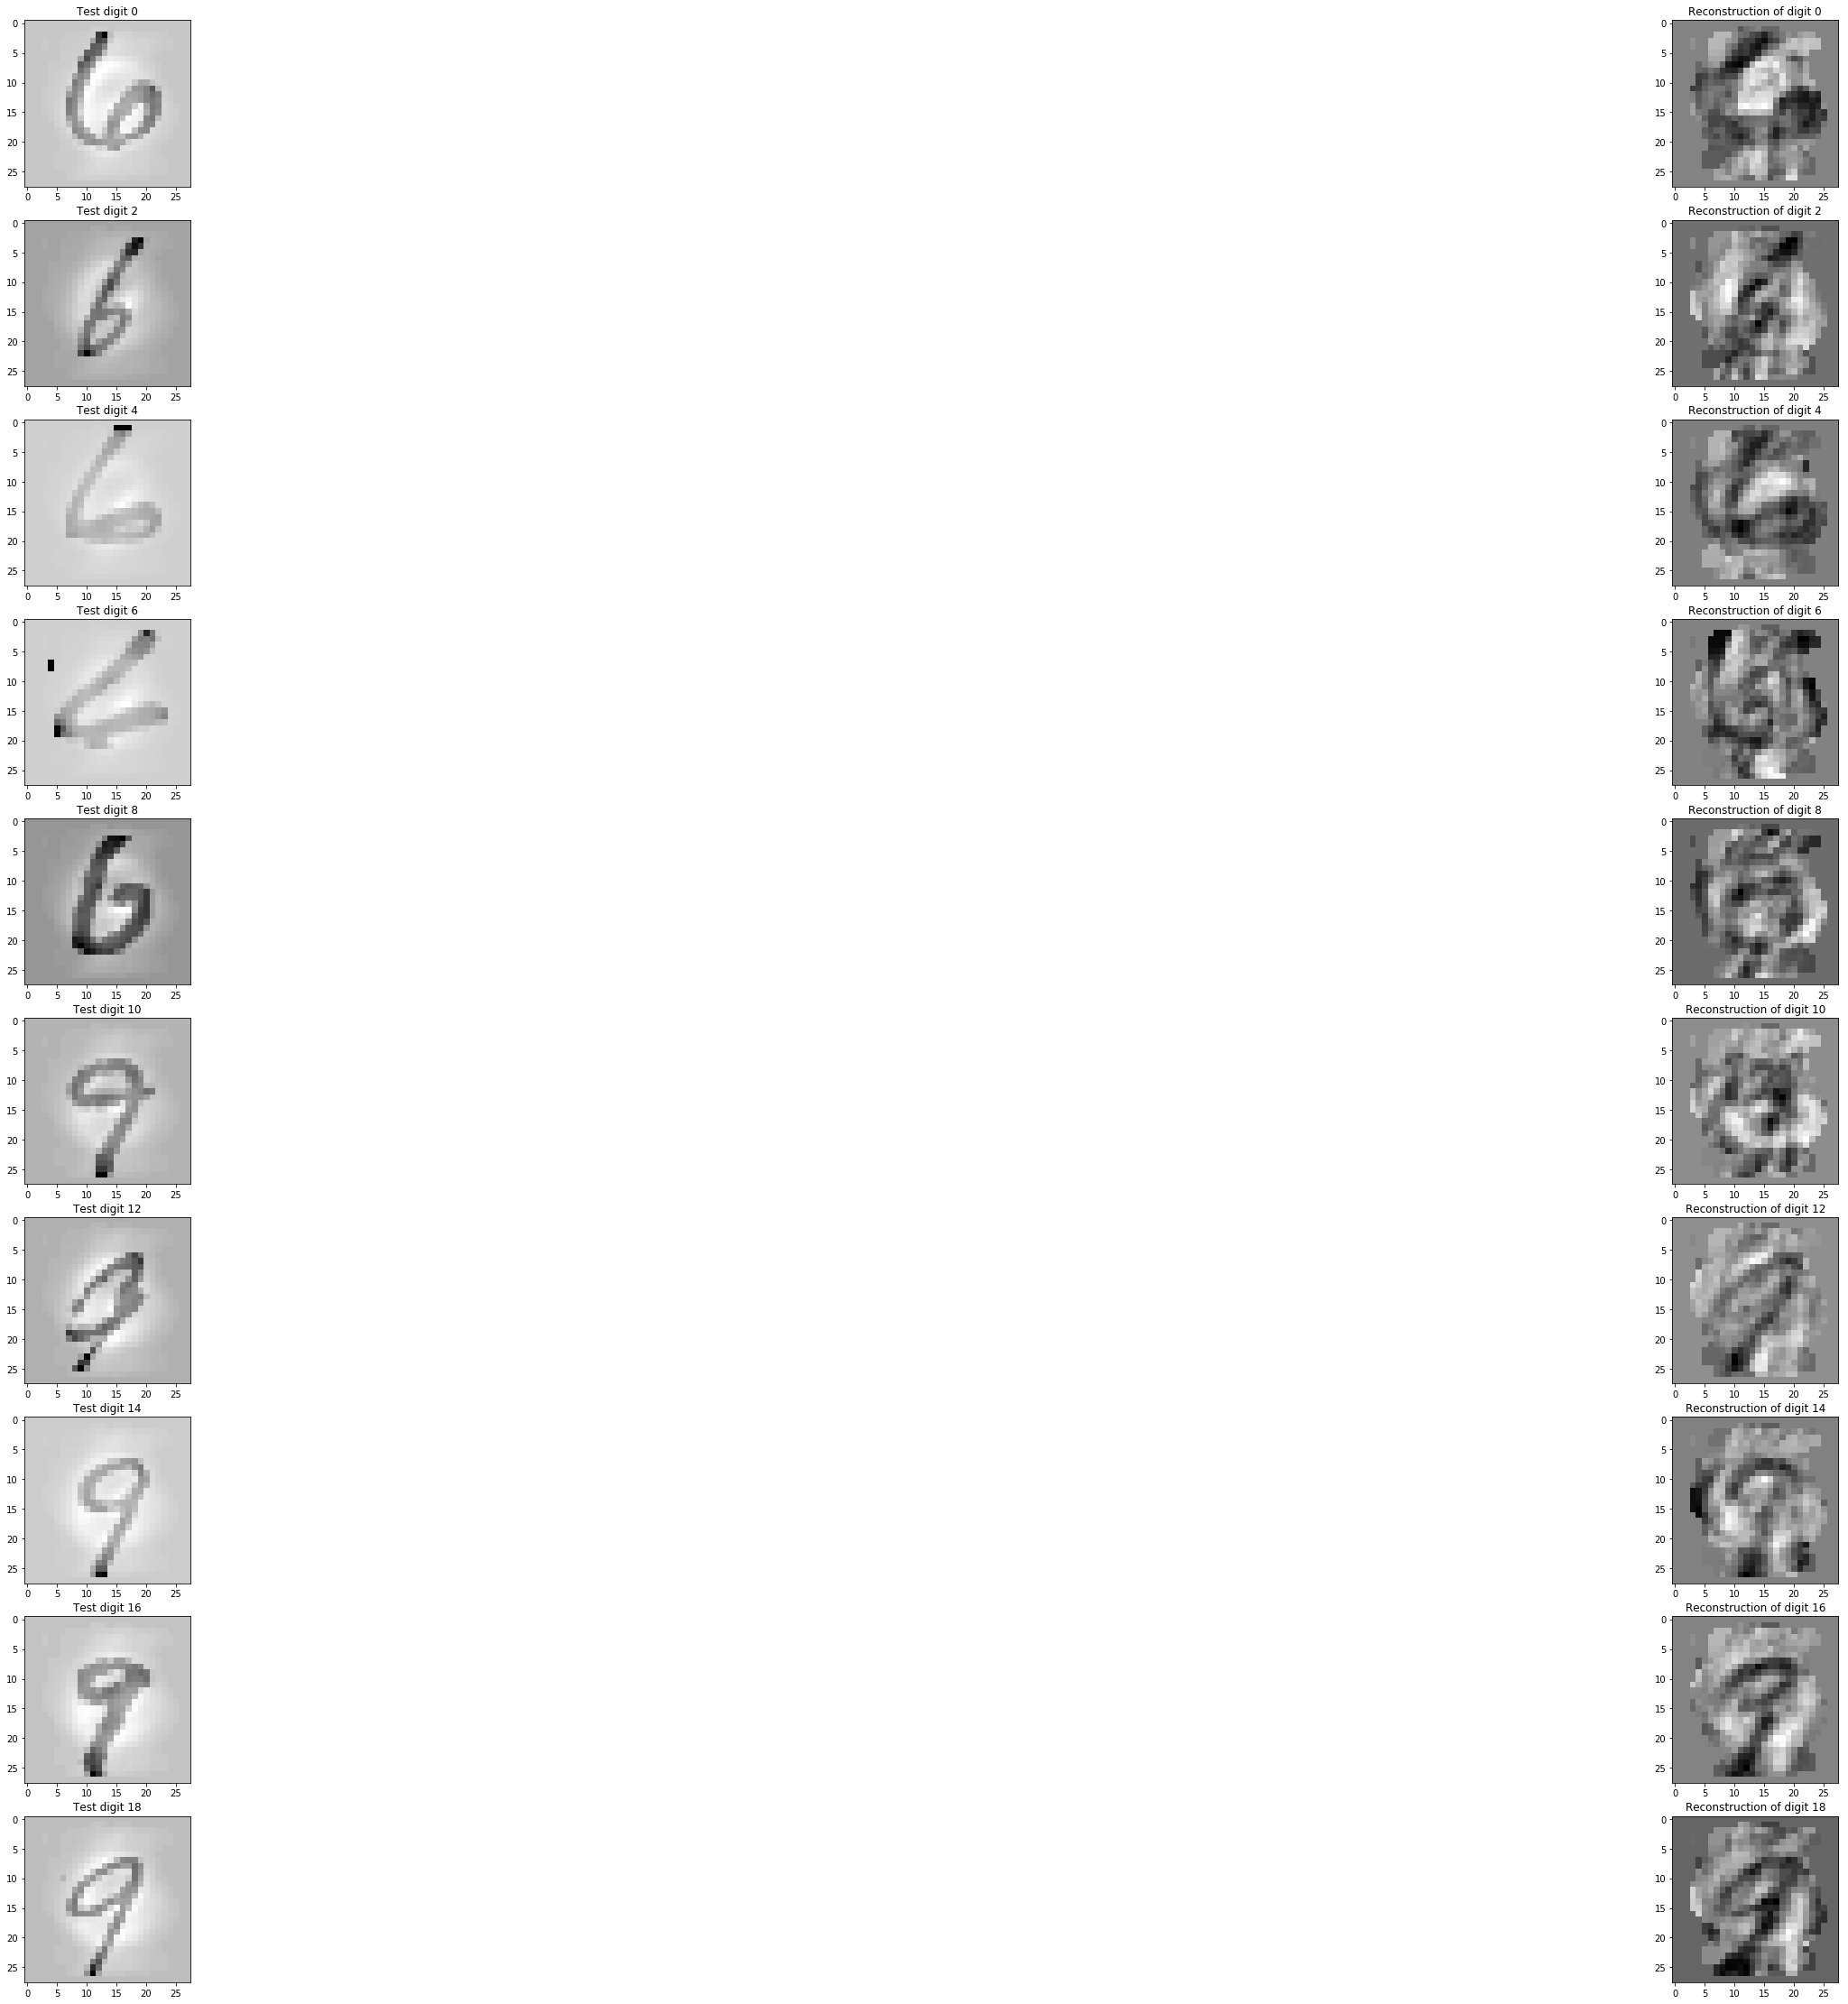

In [7]:
### Reconstruct x from y in the test set and visualize

fig, axs = plt.subplots(10,2, figsize = (60,40))
axs = axs.ravel()
for i in range(10):
    y = Y_test[i*2,:]
    x = np.dot(B.transpose(), y)
    axs[2*i].imshow(X_test[i*2,:].reshape(28,28).transpose(), cmap = cm.binary)
    axs[2*i].set_title('Test digit ' + str(i*2))
    
    axs[2*i+1].imshow(x.reshape(28,28).transpose(), cmap = cm.binary)
    axs[2*i+1].set_title('Reconstruction of digit ' + str(i*2))
plt.show()
    
#The 9s are more recognizable than the 6s.

Another possible approach to solve the problem of reconstructing **x** from **y** is to use a *generative* model and invert it with Bayes' rule. We reformulate the problem as finding the most probable **x** that could have caused **y**. That is:

argmax_**x** P(**x** | **y**)

where P(**x** | **y**) is called the posterior (probability of the stimulus being **x** if the observation is **y**). In other words, we have to define the posterior, estimate its parameters and find the argument that maximizes it, which will be the reconstruction of **x** from **y**. While, this may seem daunting, it actually has a simple solution. The posterior assigns a probability to an event by combining our observations and beliefs about it, and can be decomposed with Bayes' rule as the product of how likely our observations are given the event (probability of observing **y** if the stimulus is **x**) and how likely the event is independent of our observations (probability of the stimulus being **x**). That is:

P(**x** | **y**) ~ P(**y** | **x**) * P(**x**)

where P(**y** | **x**) is called the likelihood and P(x) is called the prior.

We will assume that the likelihood and the prior are multivariate Gaussian distributions. A Gaussian is characterized by two parameters: a mean vector and a covariance matrix. In the case of the likelihood, the mean of the Gaussian is given by:

**mu**\_likelihood = **B'** **x**

As before, we can estimate **B** in close form with ridge regression:

**B** = inv(**X**\_training' **X**\_training + lambda **I**) **X**\_training' **Y**\_training

where lambda is the regularization coefficient, I is the *p* x *p* identity matrix, and *p* is the number of pixels. The covariance matrix of the likelihood is given by:

**Sigma**_likelihood = diag(E[||**y** - **B'** **x**|| ^ 2]). 

In the case of the prior, the mean of the Gaussian is given by:

**mu**\_prior = **0** (which is a vector of zeros)

The covariance matrix of the prior is given by:

**Sigma**\_prior = **X**\_prior' * **X**\_prior / (n - 1)

where n is the length of **X**\_prior.

## Task 3 (20 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross-validation to estimate lambda and Sigma_likelihood. For simplicity, you can assume that lambda = 10 ^ -6 and Sigma_likelihood = 10 ^ -3 **I**.
* Estimate **Sigma**\_prior. Tip: Add 10 ^ -6 to the diagonal of Sigma_prior for regularization.
* Visualize **Sigma**\_prior. Can you explain what it shows? - Answered in the text block below the code

(784, 3092)


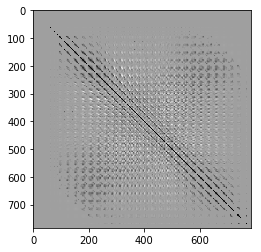

In [8]:
### Estimate B and Sigma_prior

# Specify lambda and number of pixels
lambda_ = 1e-6
numPixels = X_training.shape[1]

# Make identity matrix 
I =  np.identity(numPixels)
Sigma_likelihood = 1e-3 * np.identity(Y.shape[1])

# Compute B
B = np.linalg.inv(X_training.T @ X_training + lambda_ * I) @ X_training.T @ Y_training
print(B.shape)
#Estimate Sigma_prior
n = X_prior.shape[0]
Sigma_prior = X_prior.T @ X_prior / (n-1) 

# Add 1e-6 to Sigma prior for regularization
regularization_matrix = I * lambda_
Sigma_prior = Sigma_prior + regularization_matrix

# Plot Sigma_prior
plt.imshow(Sigma_prior, cmap = cm.binary)



**What does the visualization of Sigma prior show?**

This visualization shows the covariance matrix of all pixels found in the images in x_prior. So if you look at the diagonal (i.e. when you compare a pixel with itself), the covariance is maximal. This is why the diagonal is dark. Furthermore, because the 28x28 image is reshaped into a vector, not all neighbouring pixels are also neighbouring in the vector. This is why you see a kind of pattern of gaps.

Having defined the likelihood and the prior as Gaussians, we can derive the posterior by multiplying them. It turns out that the product of two Gaussians is another Gaussian, whose mean vector is given by:

**mu**\_posterior = inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

We are almost done. Recall that the reconstruction of **x** from **y** is the argument that maximizes the posterior, which we derived to be a Gaussian. We will be completely done once we answer the following question: What is the argument that maximizes a Gaussian?

.  
.  
.  
.  
.  
.

The answer is its mean vector, which is the solution of our initial problem. That is:

argmax_**x** P(**x** | **y**) =  
**mu**\_posterior =  
inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

Now, we can plug any **y** in the above equation and reconstruct the most probable **x** that could have caused it.


## Task 4 (25 points)

- Reconstruct **x** from **y** in the test set.
- Visualize the reconstructions.
- Compare the reconstructions with the earlier reconstructions. Which one is better? Why? Can you think of ways to improve the results?

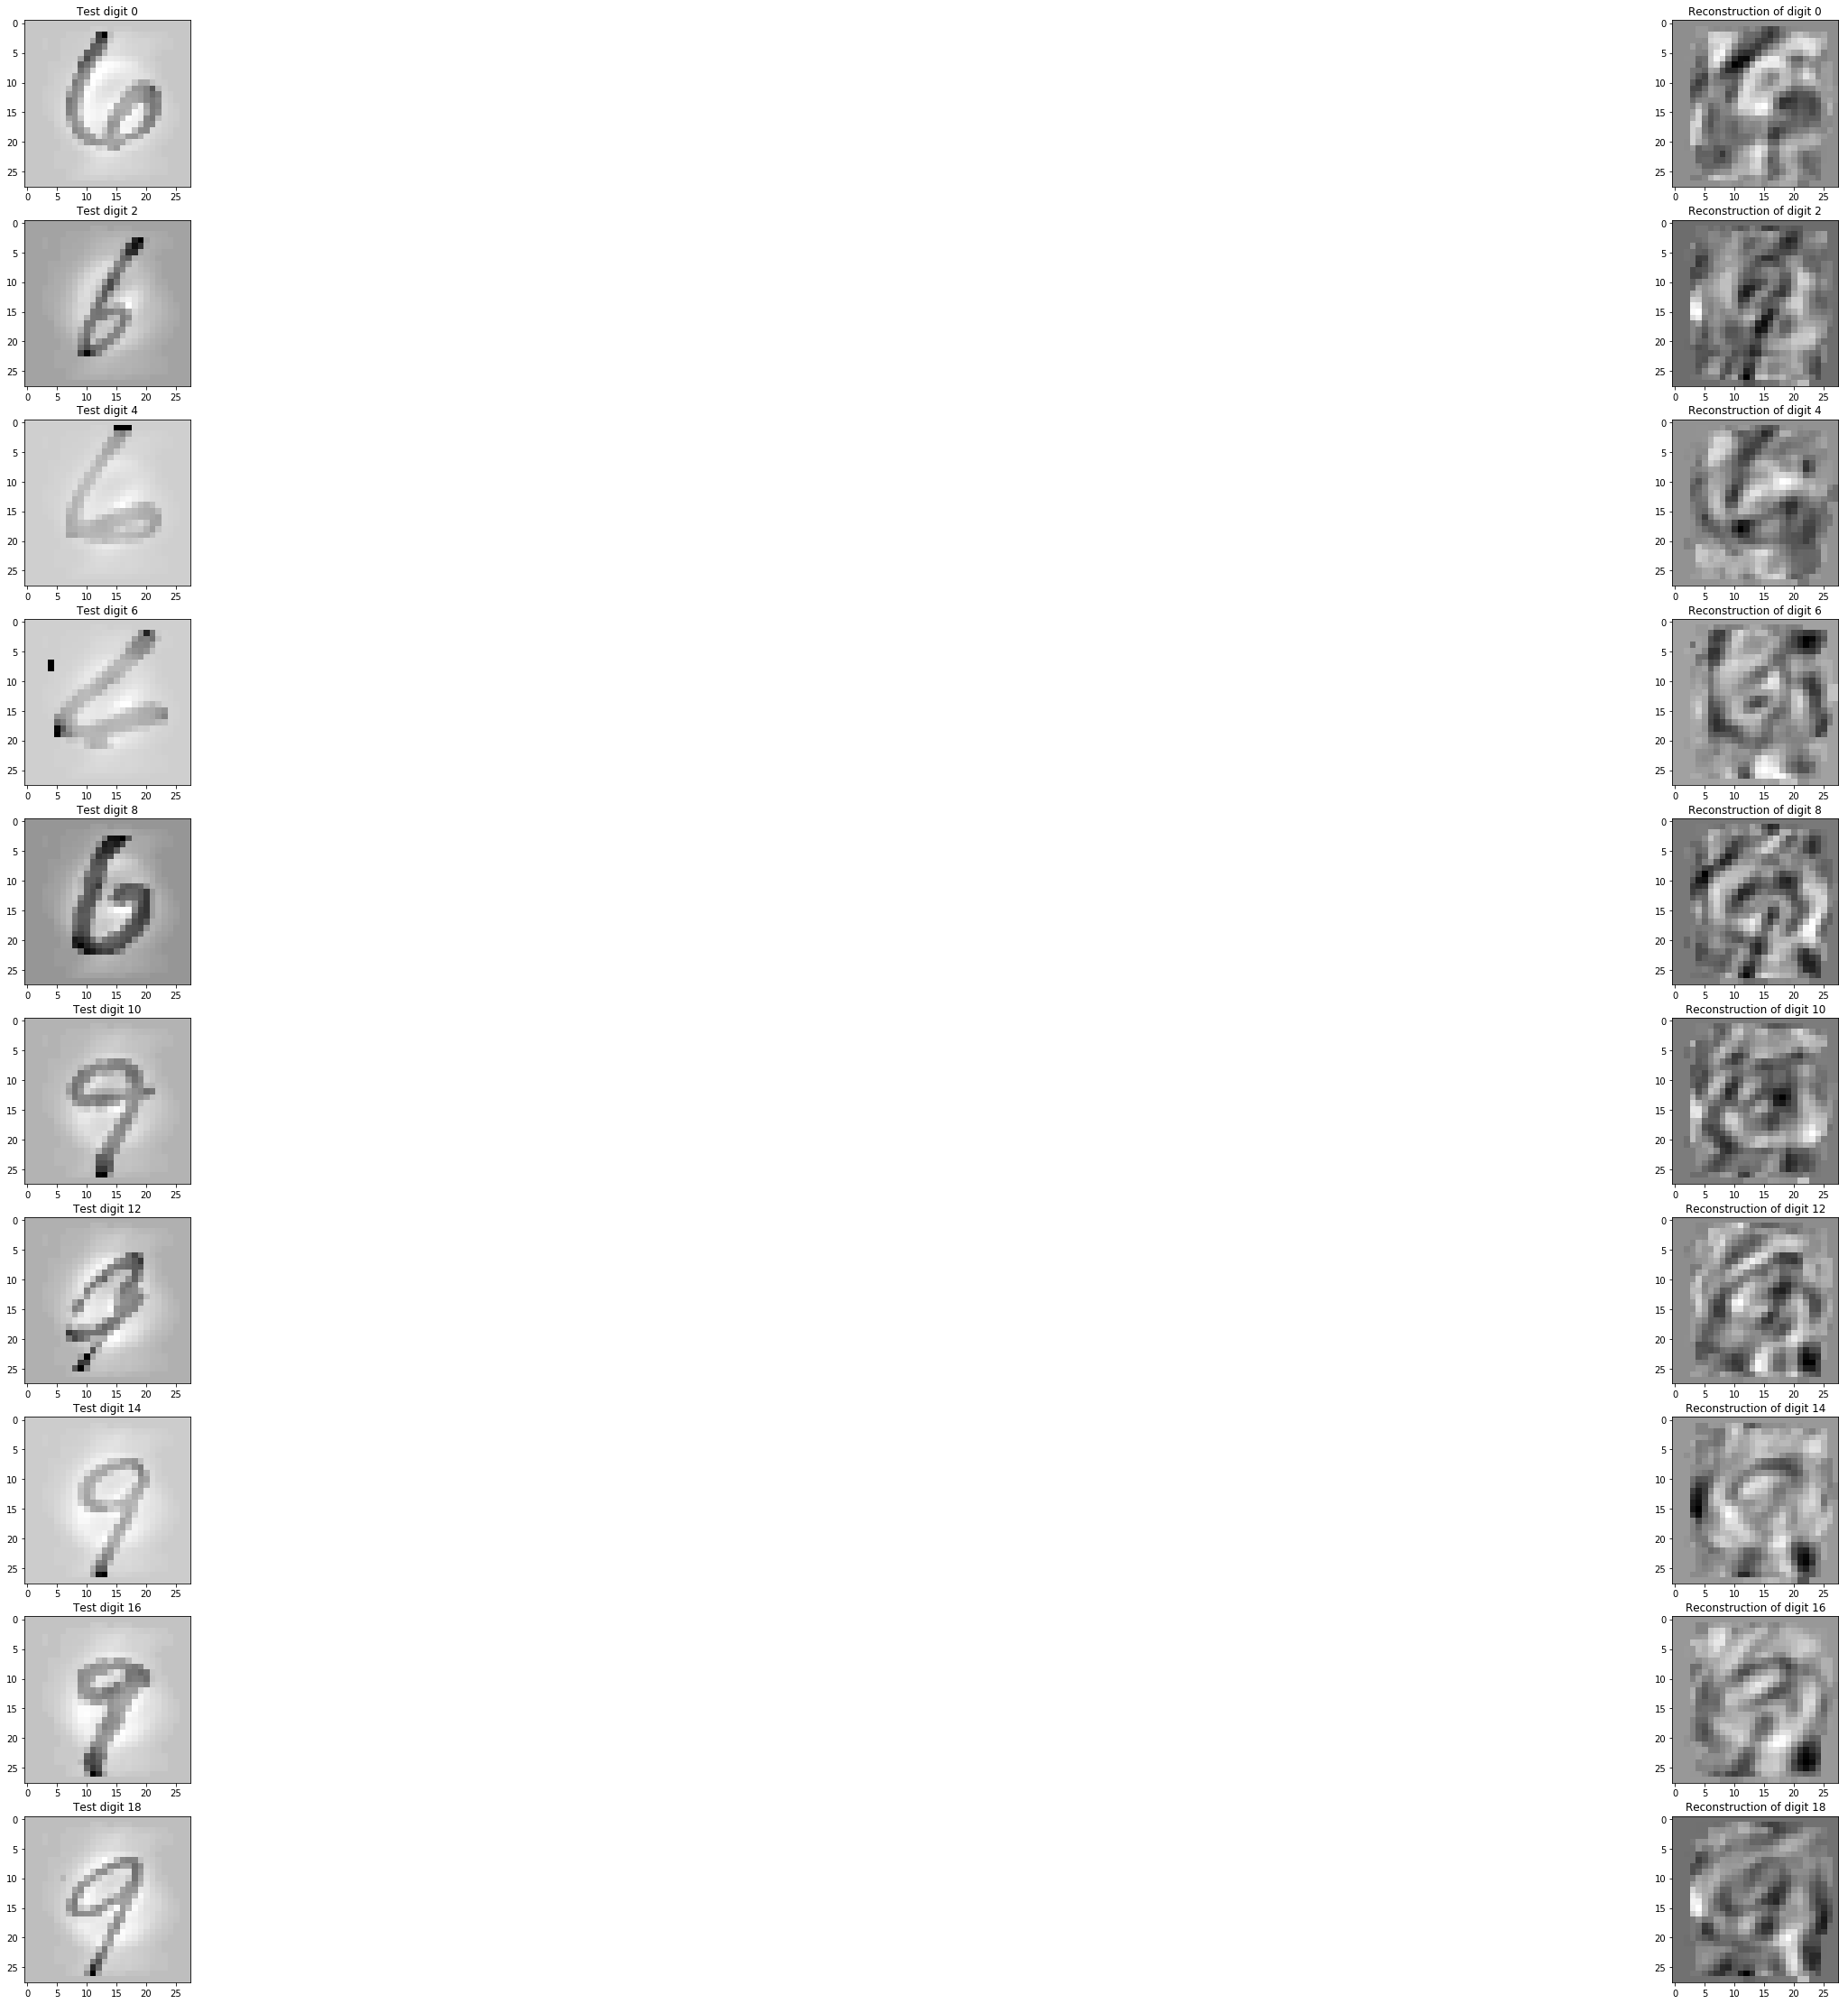

In [9]:
### Reconstruct x from y in the test set and visualize the reconstructions

Sigma_prior_inverse = np.linalg.inv(Sigma_prior)
Sigma_likelihood_inverse = np.linalg.inv(Sigma_likelihood)

fig, axs = plt.subplots(10,2, figsize = (60,40))
axs = axs.ravel()
for i in range(10):
    axs[2*i].imshow(X_test[i*2,:].reshape(28,28).transpose(), cmap = cm.binary)
    axs[2*i].set_title('Test digit ' + str(i*2))
    
    mu_posterior_first = np.linalg.inv(Sigma_prior_inverse + B @ Sigma_likelihood_inverse @ B.T) @ B
    mu_posterior_second = Sigma_likelihood_inverse @ Y_test[i*2,:]
    mu_posterior = mu_posterior_first @ mu_posterior_second
    axs[2*i+1].imshow(mu_posterior.reshape(28,28).transpose(), cmap = cm.binary)
    axs[2*i+1].set_title('Reconstruction of digit ' + str(i*2))
plt.show()

### Which reconstruction is better? 
# These new images are a little bit better: they look smoother. Maybe it could be 
# improved by not explicitely computing the inverse of matrices but instead using 
# numpy.linalg.solve. Or maybe actually using cross-validation to get lambda and 
# Sigma_likelihood would work better.




Now the real fight begins! You might have already realized that the second approach is very similar to the one in the face reconstruction paper that we have discussed in the last lecture. The main difference is how the stimuli are encoded. So far, we have been encoding the stimuli with an identity transformation:

**mu**\_likelihood = **B'** g(**x**)

where g(**x**) = **x**

In the paper, they are encoded as the features extracted from a DNN:

**mu**\_likelihood = **B'** DNN(**x**)

Similarly, we have been decoding the responses with MAP estimation of the stimuli:

g ^ -1(argmax_g(**x**) P(g(**x**) | **y**))

where g ^ -1(**y**) = **y**

In the paper, they are decoded with MAP estimation of the features followed by an inverse DNN:

DNN ^ -1(argmax_DNN(**x**) P(DNN(**x**) | **y**))

## Task 5 (30 points)

- Train a simple DNN for digit classification on the MNIST dataset.
- Select an indermediate layer of the DNN as your feature extractor.
- Train another simple DNN to invert the first DNN. That is, it should transform features extracted by the selected layer of the first DNN to stimuli.
- Repeat Task 3 but use the trained DNNs instead of identity transformation.

In [10]:
### Define a simple DNN consisting of two hidden layers.
class DNN_encode(chainer.Chain):
    def __init__(self):
        super(DNN_encode, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(28*28, 512)
            self.l2 = L.Linear(512, 256)
            self.l3 = L.Linear(256, 10)
            
    # Activation of extracted layer is used by setting extract_intermediate_layer to True
    def __call__(self, x, extract_intermediate_layer):
        h = F.relu(self.l1(x)) # Layer to be extracted
        if extract_intermediate_layer:
            return h
        h = F.relu(self.l2(h))
        h = F.dropout(h)
        h = self.l3(h)
        return h



In [11]:
### Initialization before training

epochs = 20
batchsize = 100

# Train and testset are loaded using Chainer functions
trainset, testset = chainer.datasets.get_mnist(withlabel=True)
# Only a subset of the training set is taken (5000 images), to save runtime
trainset_small, _  = chainer.datasets.split_dataset(trainset, split_at = 5000, order=None)

In [12]:
model_encode = DNN_encode()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model_encode)


In [ ]:
### Train the simple DNN

# The model is trained, after each epoch the loss (as calculated by the softmax cross entropy function) is printed
for i in range(epochs):
    print('\nEpoch: ', i)
    train_iter = chainer.iterators.SerialIterator(trainset_small, batchsize, False, True)
    for j, batch in enumerate(train_iter):
        with chainer.using_config('train', True):
            image, label = concat_examples(batch)
            pred = model_encode(image, False)
            loss = F.softmax_cross_entropy(pred, label)
            
            model_encode.cleargrads()
            loss.backward()
            
            optimizer.update()
            
    if train_iter.is_new_epoch:
        print('train_loss: {:.04f} '.format(loss.data), end='')

In [ ]:
### Save the trained model

serializers.save_npz('dnn_mnist.model', model_encode)

In [13]:
# Create an instance of the trained networked
model_encode = DNN_encode()

# Load the saved parameters into the instance
serializers.load_npz('dnn_mnist.model', model_encode)

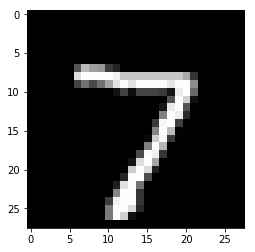

Should be digit:  7
Predicted to be digit:  7


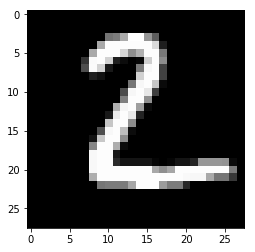

Should be digit:  2
Predicted to be digit:  2


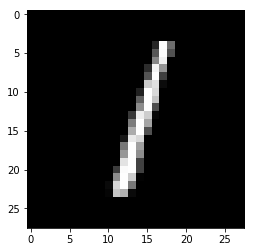

Should be digit:  1
Predicted to be digit:  1


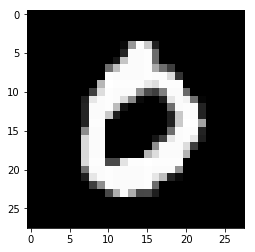

Should be digit:  0
Predicted to be digit:  0


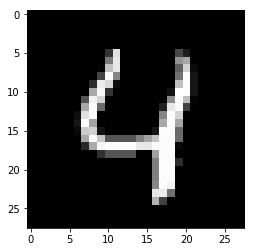

Should be digit:  4
Predicted to be digit:  4


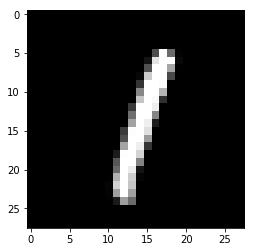

Should be digit:  1
Predicted to be digit:  1


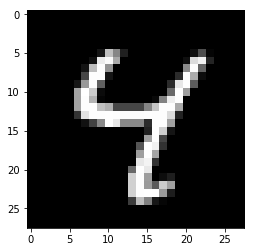

Should be digit:  4
Predicted to be digit:  4


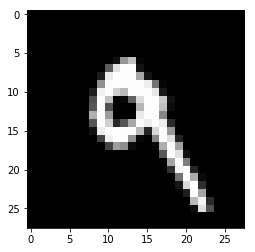

Should be digit:  9
Predicted to be digit:  9


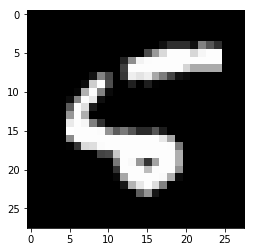

Should be digit:  5
Predicted to be digit:  6


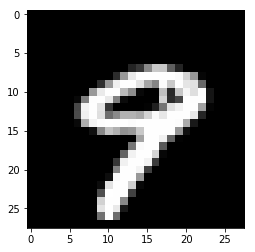

Should be digit:  9
Predicted to be digit:  9


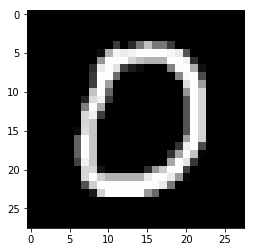

Should be digit:  0
Predicted to be digit:  0


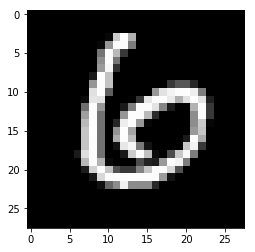

Should be digit:  6
Predicted to be digit:  6


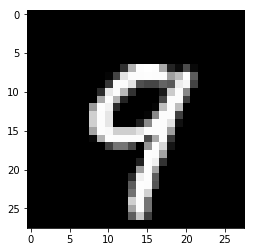

Should be digit:  9
Predicted to be digit:  9


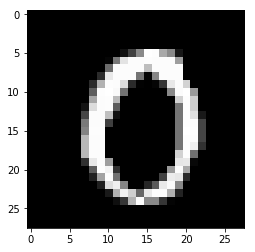

Should be digit:  0
Predicted to be digit:  0


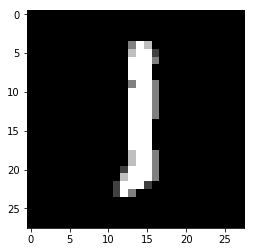

Should be digit:  1
Predicted to be digit:  1


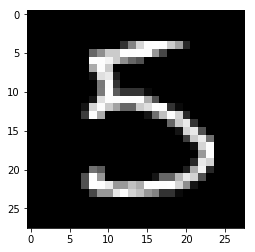

Should be digit:  5
Predicted to be digit:  5


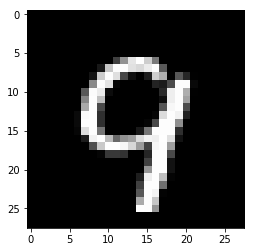

Should be digit:  9
Predicted to be digit:  9


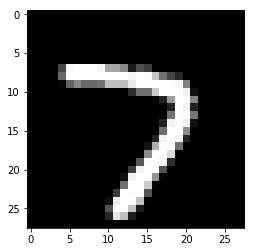

Should be digit:  7
Predicted to be digit:  7


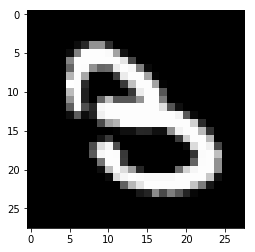

Should be digit:  3
Predicted to be digit:  3


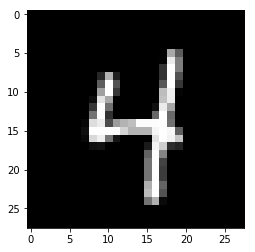

Should be digit:  4
Predicted to be digit:  4


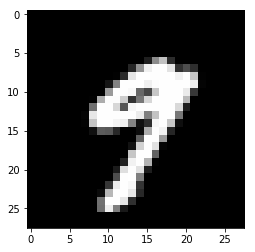

Should be digit:  9
Predicted to be digit:  9


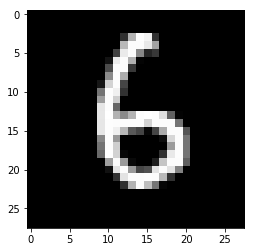

Should be digit:  6
Predicted to be digit:  6


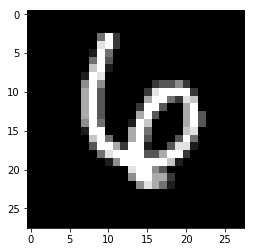

Should be digit:  6
Predicted to be digit:  6


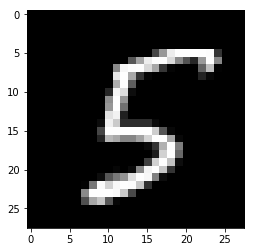

Should be digit:  5
Predicted to be digit:  5


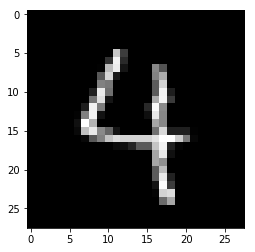

Should be digit:  4
Predicted to be digit:  4


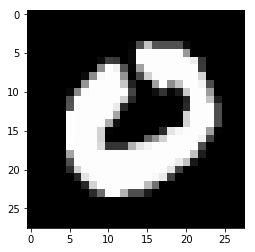

Should be digit:  0
Predicted to be digit:  0


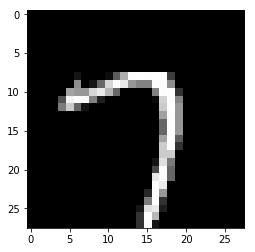

Should be digit:  7
Predicted to be digit:  7


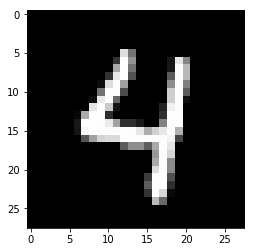

Should be digit:  4
Predicted to be digit:  4


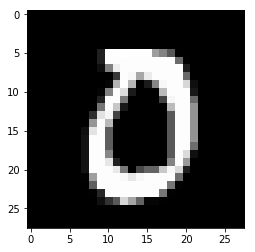

Should be digit:  0
Predicted to be digit:  0


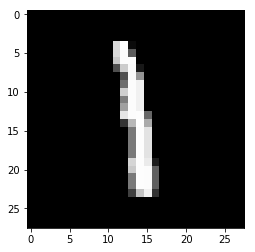

Should be digit:  1
Predicted to be digit:  1


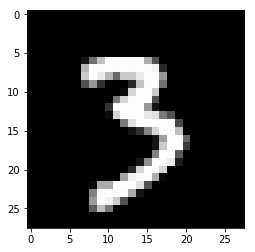

Should be digit:  3
Predicted to be digit:  3


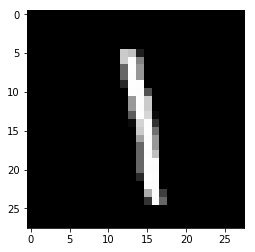

Should be digit:  1
Predicted to be digit:  1


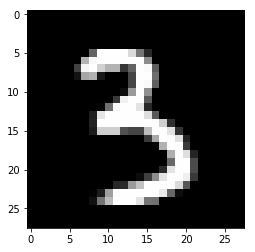

Should be digit:  3
Predicted to be digit:  3


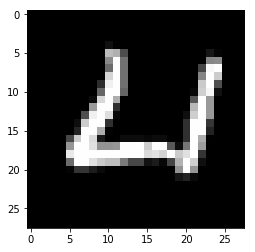

Should be digit:  4
Predicted to be digit:  4


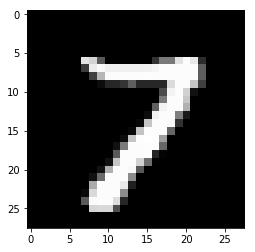

Should be digit:  7
Predicted to be digit:  7


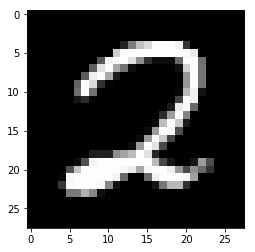

Should be digit:  2
Predicted to be digit:  2


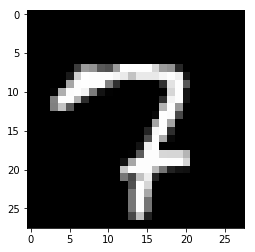

Should be digit:  7
Predicted to be digit:  7


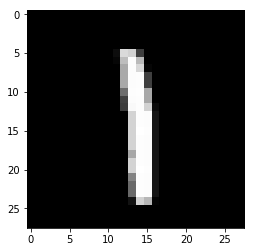

Should be digit:  1
Predicted to be digit:  1


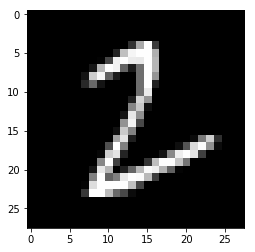

Should be digit:  2
Predicted to be digit:  2


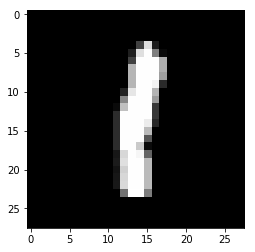

Should be digit:  1
Predicted to be digit:  1


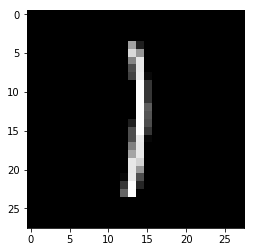

Should be digit:  1
Predicted to be digit:  1


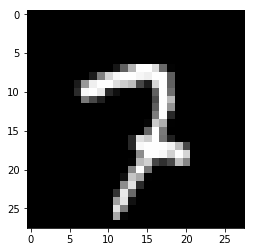

Should be digit:  7
Predicted to be digit:  7


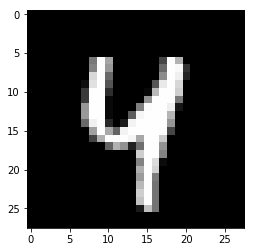

Should be digit:  4
Predicted to be digit:  4


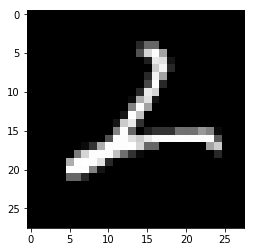

Should be digit:  2
Predicted to be digit:  2


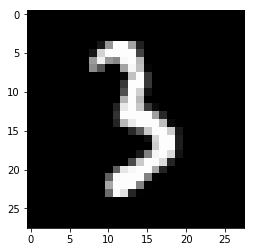

Should be digit:  3
Predicted to be digit:  3


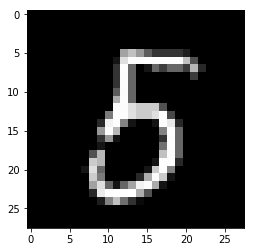

Should be digit:  5
Predicted to be digit:  5


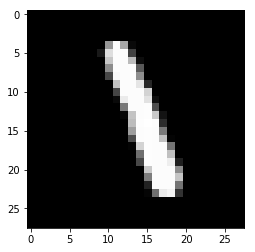

Should be digit:  1
Predicted to be digit:  1


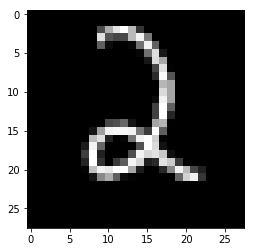

Should be digit:  2
Predicted to be digit:  2


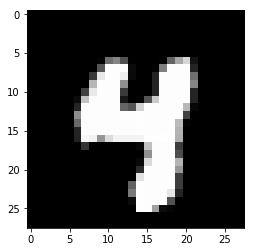

Should be digit:  4
Predicted to be digit:  4


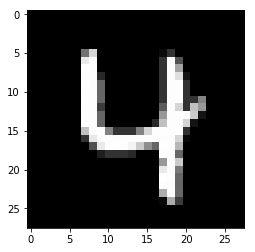

Should be digit:  4
Predicted to be digit:  4


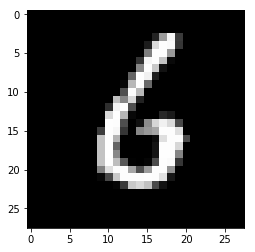

Should be digit:  6
Predicted to be digit:  6


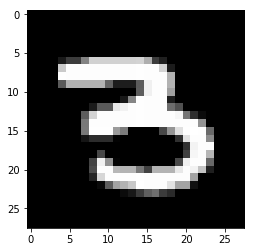

Should be digit:  3
Predicted to be digit:  3


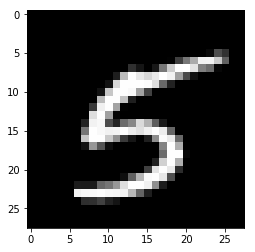

Should be digit:  5
Predicted to be digit:  5


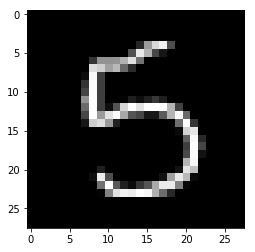

Should be digit:  5
Predicted to be digit:  5


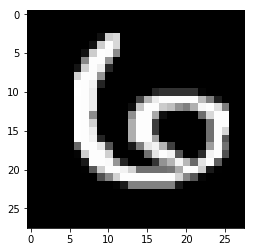

Should be digit:  6
Predicted to be digit:  6


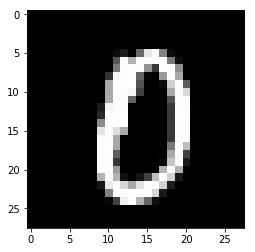

Should be digit:  0
Predicted to be digit:  0


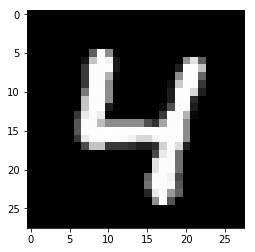

Should be digit:  4
Predicted to be digit:  4


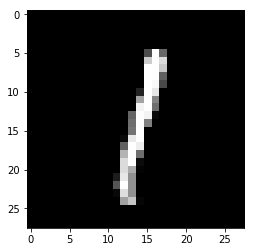

Should be digit:  1
Predicted to be digit:  1


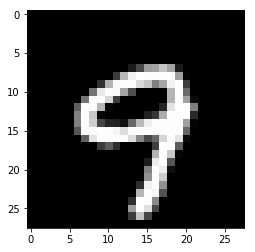

Should be digit:  9
Predicted to be digit:  9


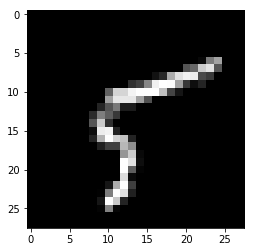

Should be digit:  5
Predicted to be digit:  5


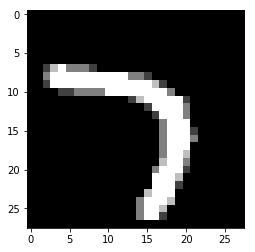

Should be digit:  7
Predicted to be digit:  7


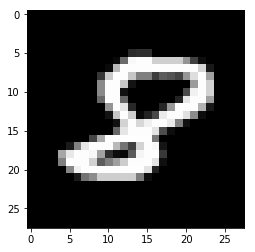

Should be digit:  8
Predicted to be digit:  8


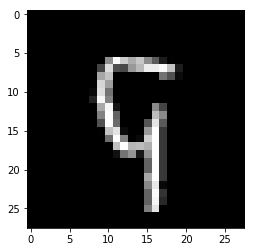

Should be digit:  9
Predicted to be digit:  9


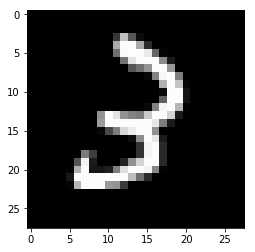

Should be digit:  3
Predicted to be digit:  3


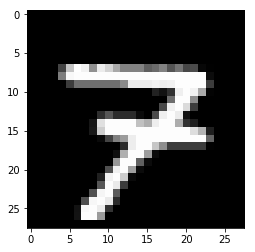

Should be digit:  7
Predicted to be digit:  7


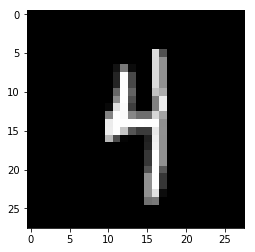

Should be digit:  4
Predicted to be digit:  4


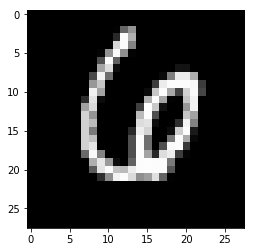

Should be digit:  6
Predicted to be digit:  2


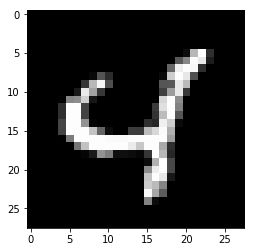

Should be digit:  4
Predicted to be digit:  4


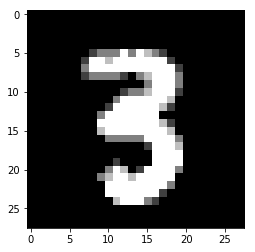

Should be digit:  3
Predicted to be digit:  3


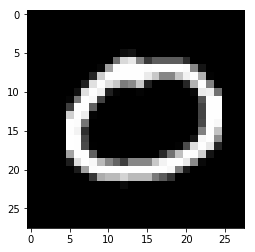

Should be digit:  0
Predicted to be digit:  0


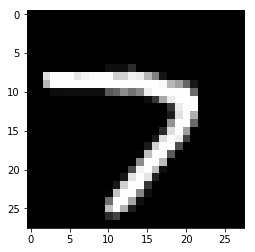

Should be digit:  7
Predicted to be digit:  7


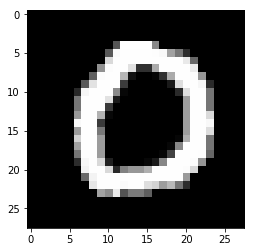

Should be digit:  0
Predicted to be digit:  0


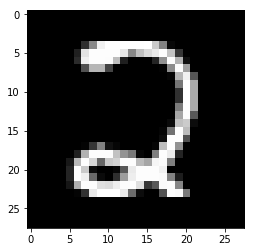

Should be digit:  2
Predicted to be digit:  2


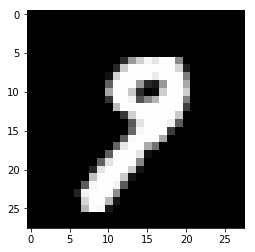

Should be digit:  9
Predicted to be digit:  9


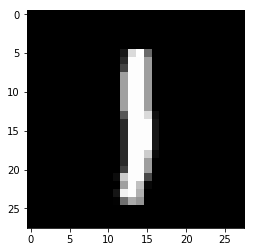

Should be digit:  1
Predicted to be digit:  1


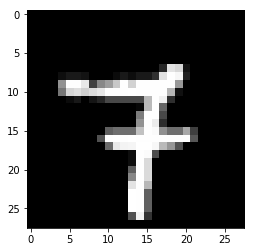

Should be digit:  7
Predicted to be digit:  7


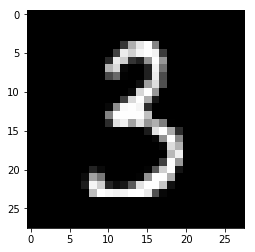

Should be digit:  3
Predicted to be digit:  3


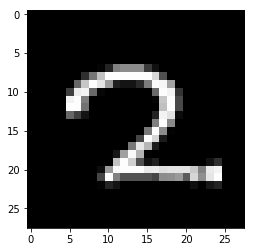

Should be digit:  2
Predicted to be digit:  2


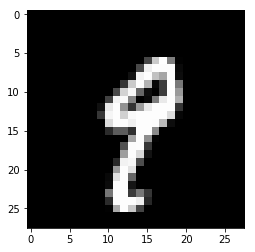

Should be digit:  9
Predicted to be digit:  9


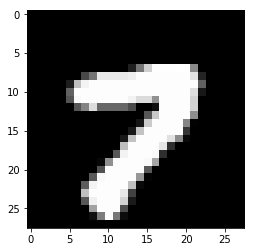

Should be digit:  7
Predicted to be digit:  7


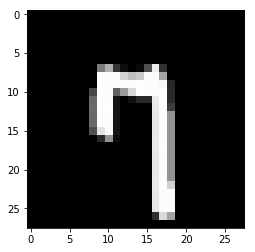

Should be digit:  7
Predicted to be digit:  7


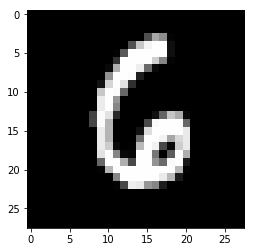

Should be digit:  6
Predicted to be digit:  6


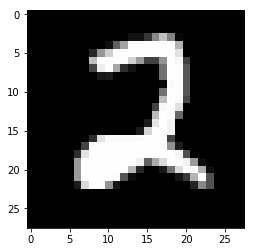

Should be digit:  2
Predicted to be digit:  2


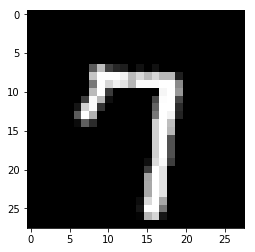

Should be digit:  7
Predicted to be digit:  7


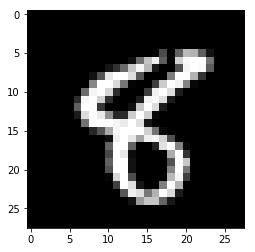

Should be digit:  8
Predicted to be digit:  8


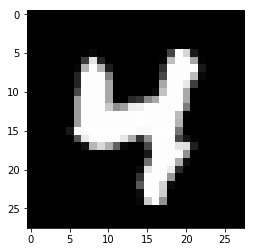

Should be digit:  4
Predicted to be digit:  4


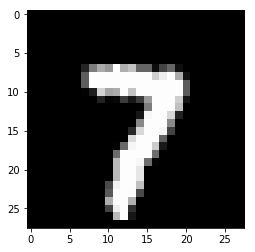

Should be digit:  7
Predicted to be digit:  7


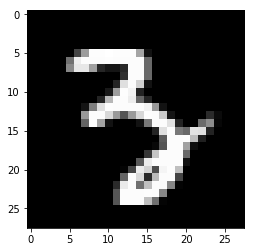

Should be digit:  3
Predicted to be digit:  3


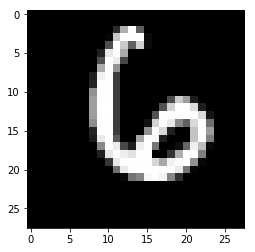

Should be digit:  6
Predicted to be digit:  6


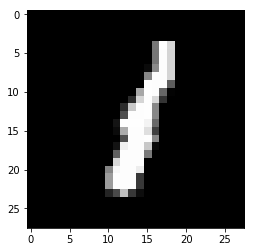

Should be digit:  1
Predicted to be digit:  1


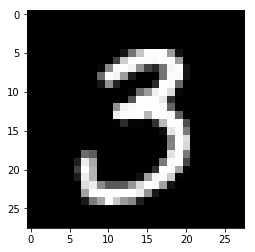

Should be digit:  3
Predicted to be digit:  3


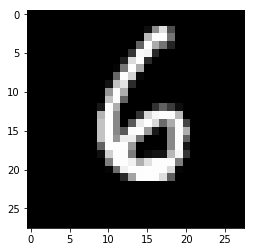

Should be digit:  6
Predicted to be digit:  6


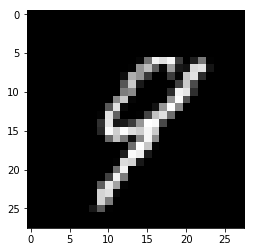

Should be digit:  9
Predicted to be digit:  4


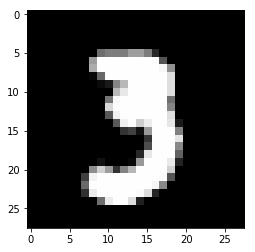

Should be digit:  3
Predicted to be digit:  3


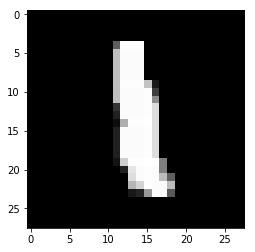

Should be digit:  1
Predicted to be digit:  1


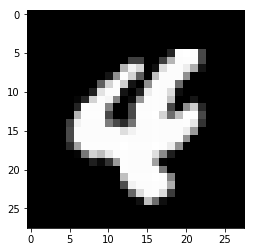

Should be digit:  4
Predicted to be digit:  4


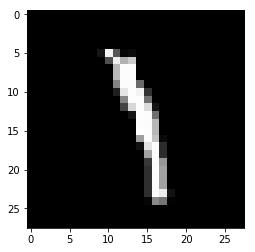

Should be digit:  1
Predicted to be digit:  1


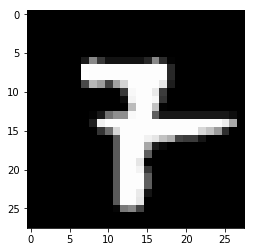

Should be digit:  7
Predicted to be digit:  7


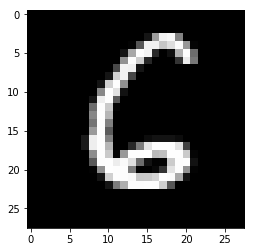

Should be digit:  6
Predicted to be digit:  6


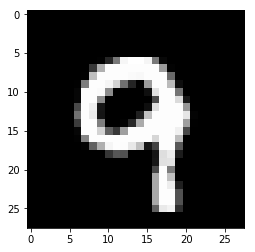

Should be digit:  9
Predicted to be digit:  9


In [14]:
### Visualize the results as a check: looks good

%matplotlib inline
# We also went through the test set to look at the results of the encoder on the testset
test_iter = chainer.iterators.SerialIterator(testset, batchsize, repeat=False, shuffle=False)


first_batch = True
for j, batch in enumerate(test_iter):
    with chainer.using_config('train', False):
        images, labels = concat_examples(batch)
        preds = model_encode(images, False)
        loss = F.softmax_cross_entropy(preds, labels)
        if first_batch:
            for input_ in (range(preds.shape[0])):
                image = images[input_]
                label = labels[input_]
                pred_ = preds[input_].data
                pred_label = pred_.argmax()
                plt.imshow(image.reshape(28, 28), cmap='gray')
                plt.show()
                print("Should be digit: ", label)
                print("Predicted to be digit: ", pred_label)
        first_batch = False


In [15]:
# Very simple DNN consisting of just one input and one output layer
class DNN_decode(chainer.Chain):

    def __init__(self):
        super(DNN_decode, self).__init__()
        with self.init_scope():
            self.l2 = L.Linear(512, 28*28)


    def __call__(self, x):
        h = self.l2(x)
        return h



In [16]:
### Preparations before training

model_decode = DNN_decode()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model_decode)
batchsize = 100
epochs = 5

In [17]:
### Training of the second DNN

# The model is trained: The MNIST images are passed to the encoder and the activations from the second hidden layer
# are extracted. These features are passed as an input to the decoder, which is trained to re-generate the stimuli
# corresponding to the features. Mean squared errors is used as a loss function.
for i in range(epochs):
    print('\nEpoch: ', i)
    train_iter = chainer.iterators.SerialIterator(trainset_small, batchsize, False, True)
    for j, batch in enumerate(train_iter):
        with chainer.using_config('train', True):
            print('\nIteration: ', j)
            image, label = concat_examples(batch)
            feature = model_encode(image, True)
            pred = model_decode(feature)
            loss = F.mean_squared_error(pred, image)
            
            model_decode.cleargrads()
            loss.backward()
            
            optimizer.update()
            
    if train_iter.is_new_epoch:
        print('train_loss: {:.04f} '.format(loss.data), end='')


Epoch:  0

Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4

Iteration:  5

Iteration:  6


C:\Users\Djamari\Anaconda2\envs\py3k6\lib\site-packages\chainer\optimizers\adam.py:111: RuntimeWarning: invalid value encountered in sqrt
  param.data -= hp.eta * (self.lr * m / (numpy.sqrt(vhat) + hp.eps) +



Iteration:  7

Iteration:  8

Iteration:  9

Iteration:  10

Iteration:  11

Iteration:  12

Iteration:  13

Iteration:  14

Iteration:  15

Iteration:  16

Iteration:  17

Iteration:  18

Iteration:  19

Iteration:  20

Iteration:  21

Iteration:  22

Iteration:  23

Iteration:  24

Iteration:  25

Iteration:  26

Iteration:  27

Iteration:  28

Iteration:  29

Iteration:  30

Iteration:  31

Iteration:  32

Iteration:  33

Iteration:  34

Iteration:  35

Iteration:  36

Iteration:  37

Iteration:  38

Iteration:  39

Iteration:  40

Iteration:  41

Iteration:  42

Iteration:  43

Iteration:  44

Iteration:  45

Iteration:  46

Iteration:  47

Iteration:  48

Iteration:  49
train_loss: 0.0500 
Epoch:  1

Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4

Iteration:  5

Iteration:  6

Iteration:  7

Iteration:  8

Iteration:  9

Iteration:  10

Iteration:  11

Iteration:  12

Iteration:  13

Iteration:  14

Iteration:  15

Iteration:  16

Iteration:  17

Iterat

(100, 512)
Image with label:  7


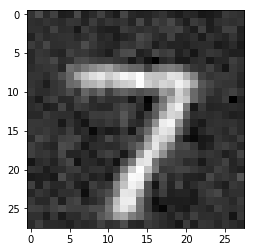

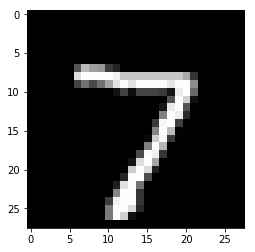

Image with label:  2


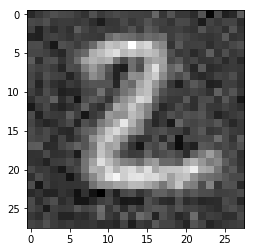

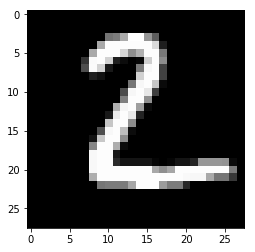

Image with label:  1


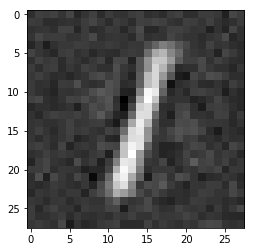

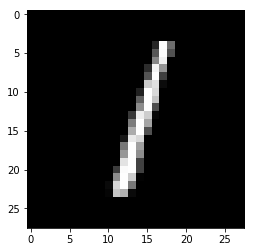

Image with label:  0


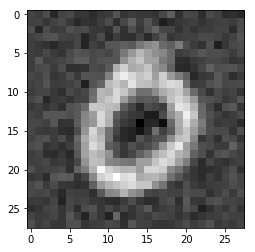

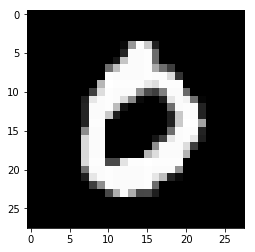

Image with label:  4


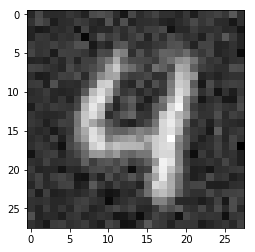

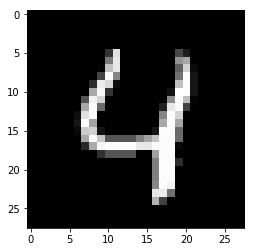

Image with label:  1


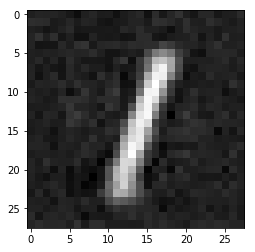

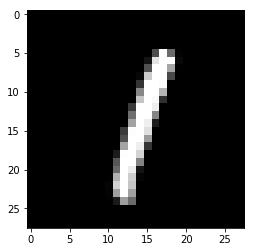

Image with label:  4


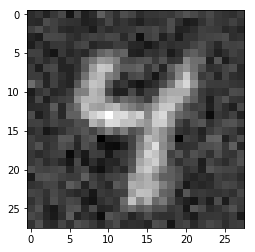

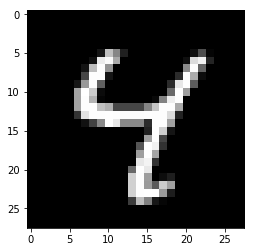

Image with label:  9


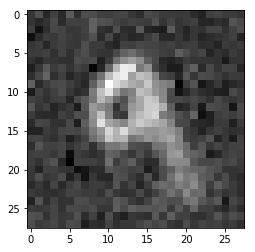

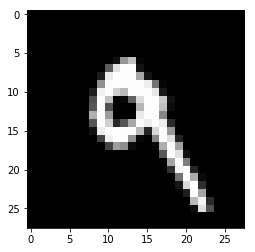

Image with label:  5


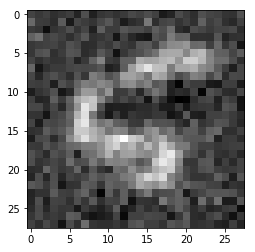

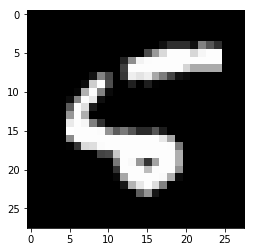

Image with label:  9


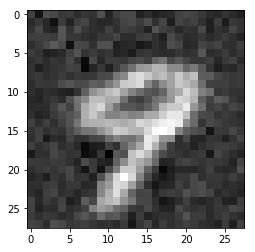

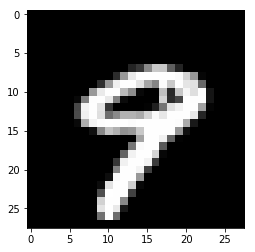

Image with label:  0


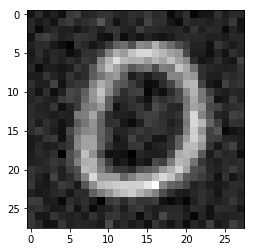

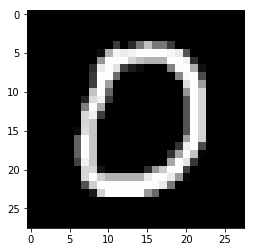

Image with label:  6


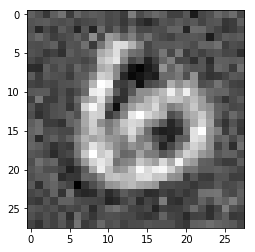

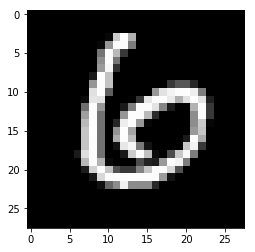

Image with label:  9


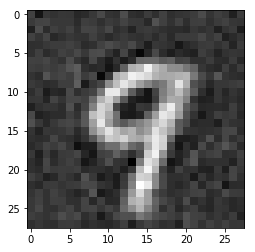

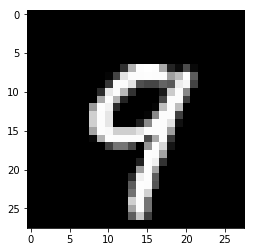

Image with label:  0


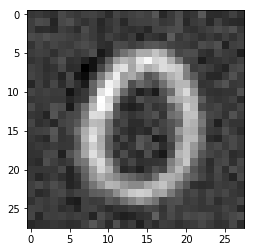

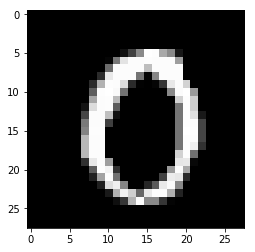

Image with label:  1


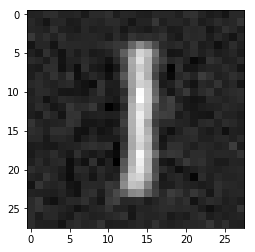

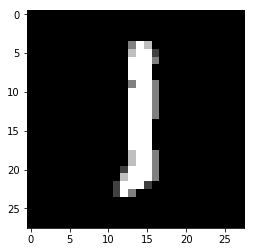

Image with label:  5


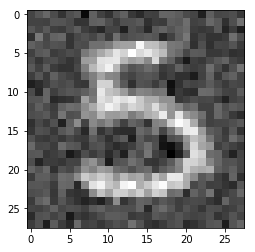

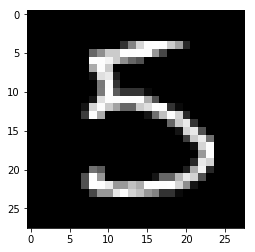

Image with label:  9


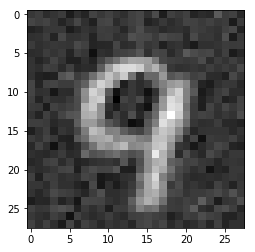

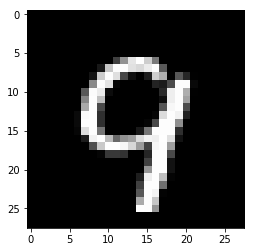

Image with label:  7


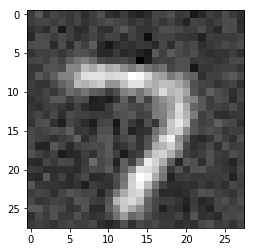

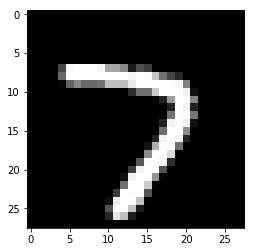

Image with label:  3


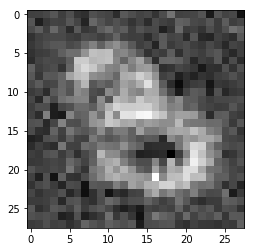

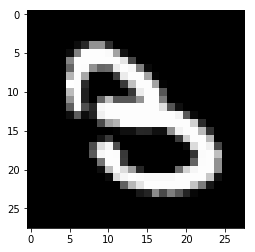

Image with label:  4


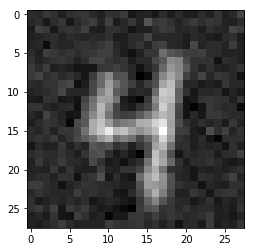

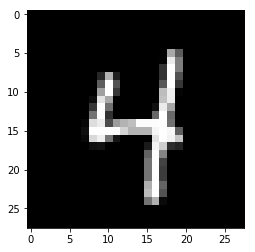

Image with label:  9


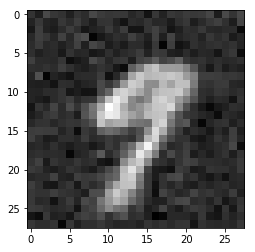

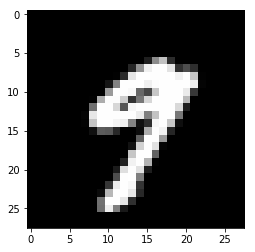

Image with label:  6


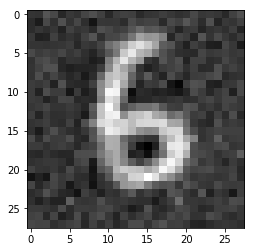

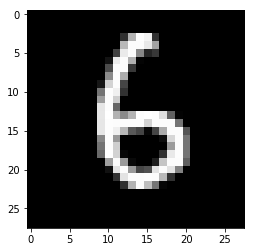

Image with label:  6


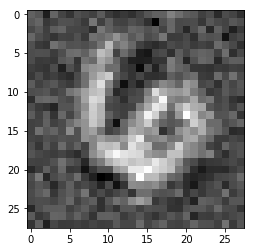

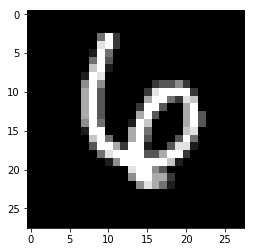

Image with label:  5


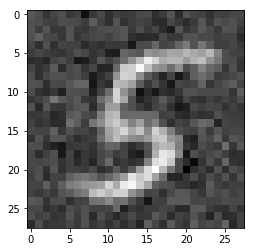

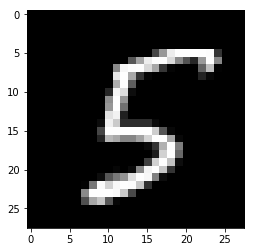

Image with label:  4


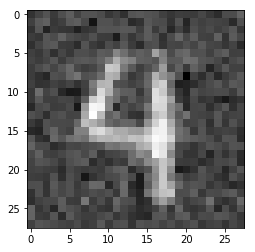

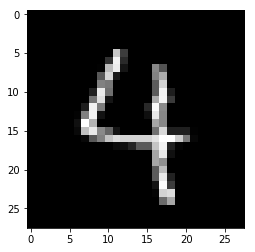

Image with label:  0


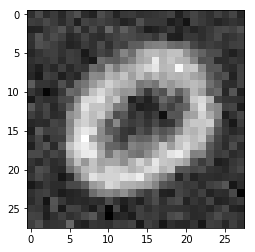

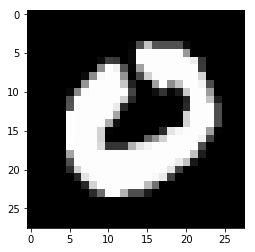

Image with label:  7


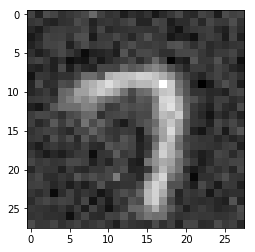

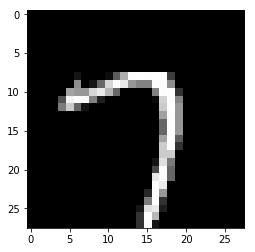

Image with label:  4


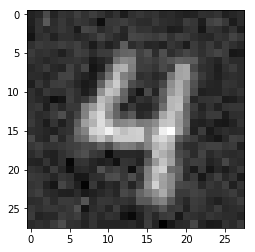

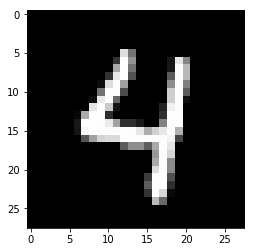

Image with label:  0


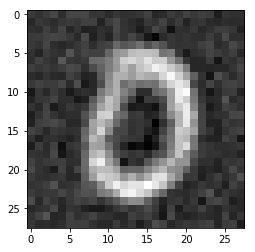

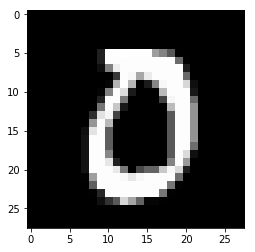

Image with label:  1


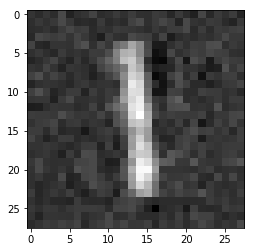

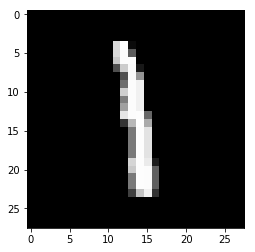

Image with label:  3


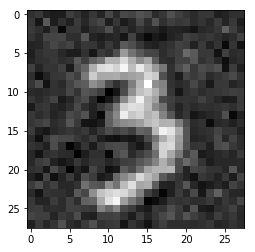

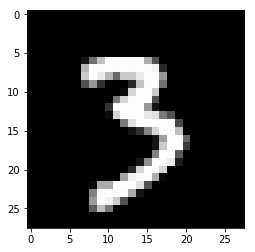

Image with label:  1


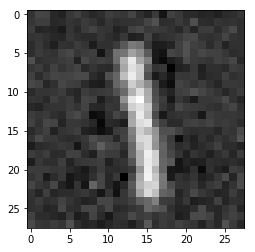

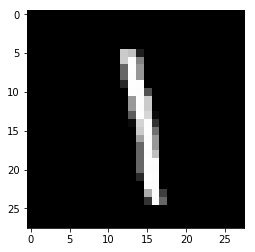

Image with label:  3


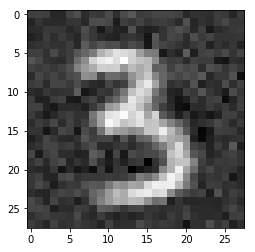

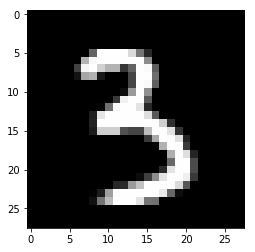

Image with label:  4


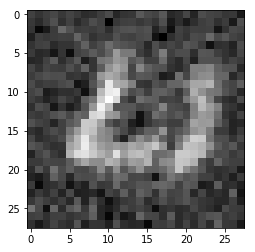

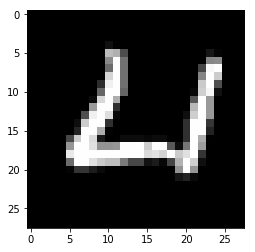

Image with label:  7


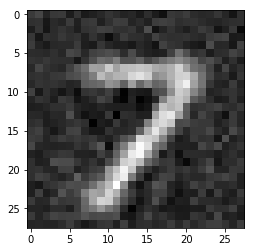

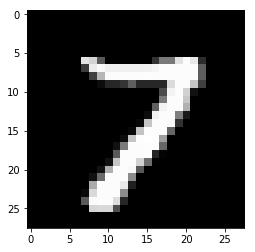

Image with label:  2


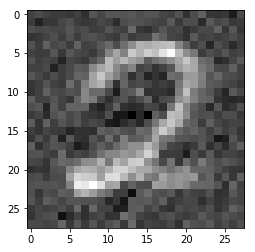

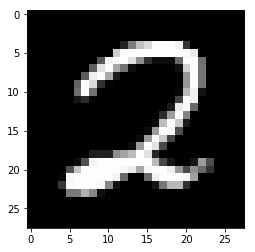

Image with label:  7


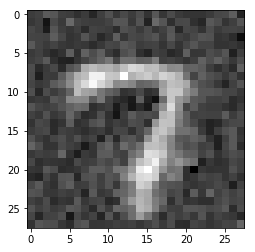

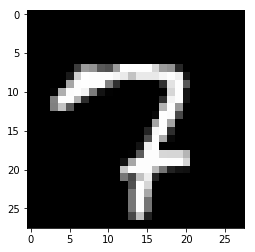

Image with label:  1


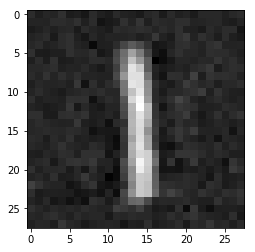

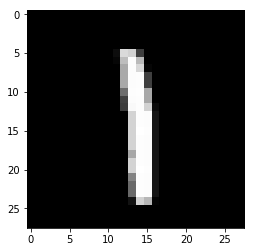

Image with label:  2


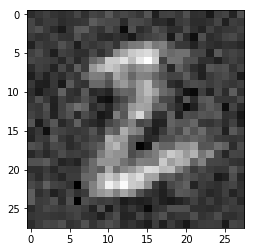

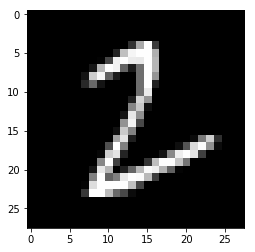

Image with label:  1


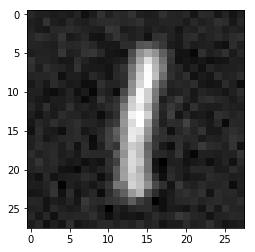

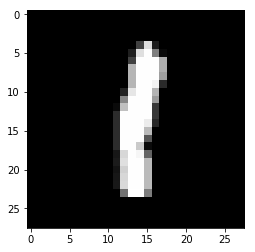

Image with label:  1


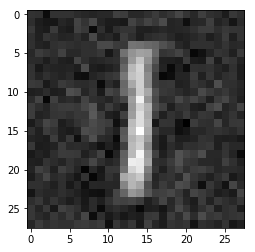

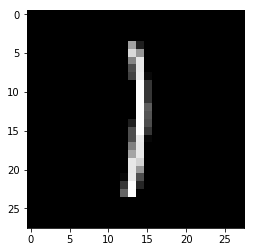

Image with label:  7


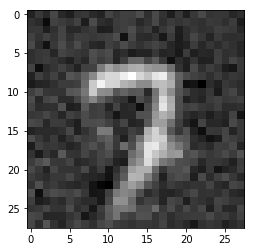

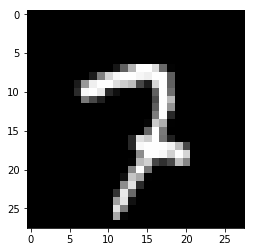

Image with label:  4


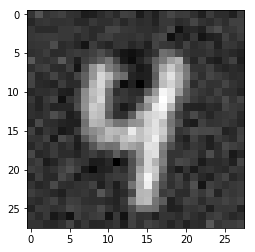

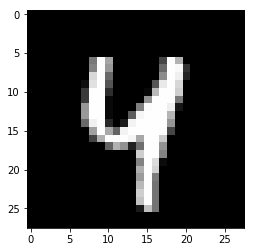

Image with label:  2


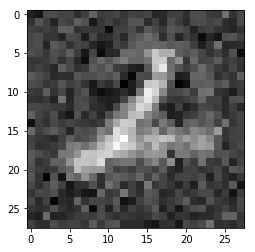

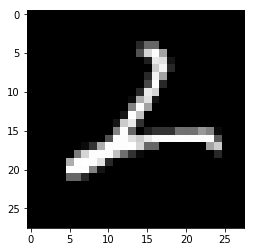

Image with label:  3


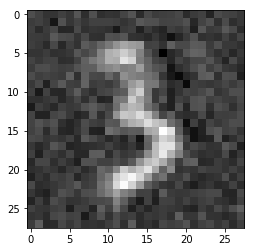

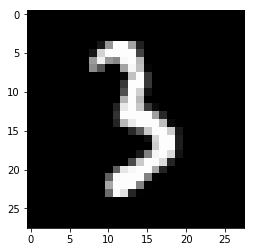

Image with label:  5


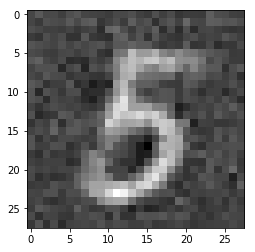

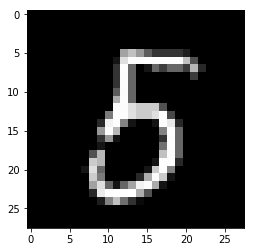

Image with label:  1


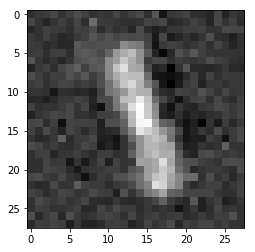

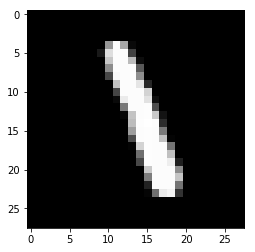

Image with label:  2


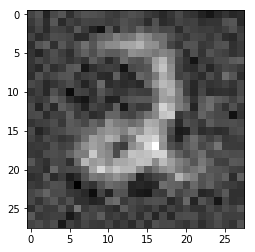

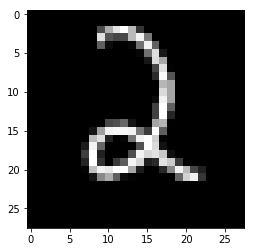

Image with label:  4


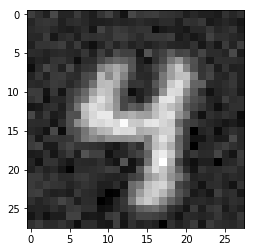

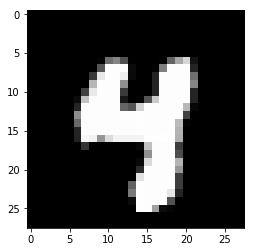

Image with label:  4


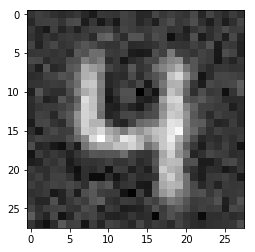

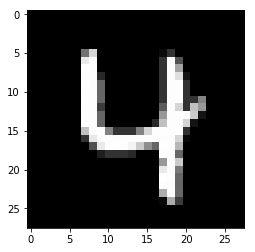

Image with label:  6


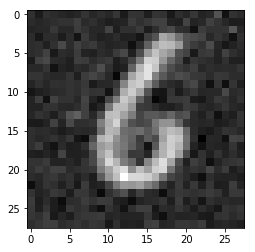

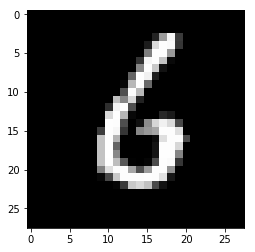

Image with label:  3


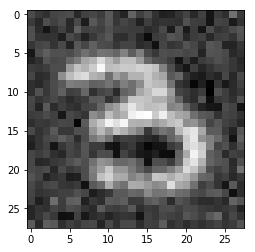

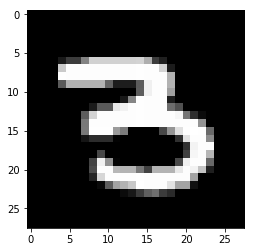

Image with label:  5


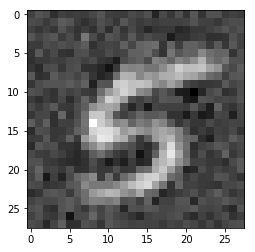

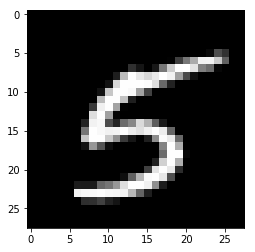

Image with label:  5


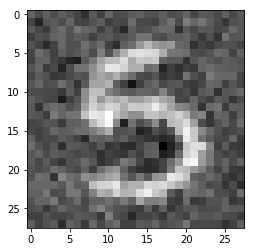

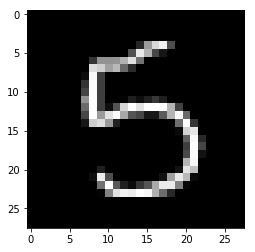

Image with label:  6


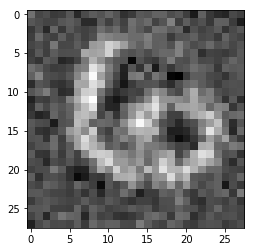

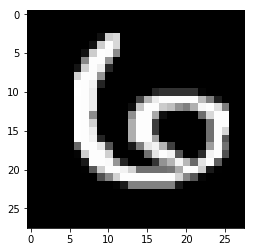

Image with label:  0


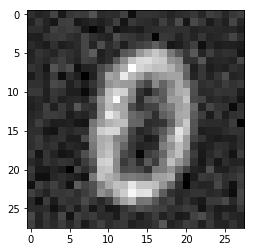

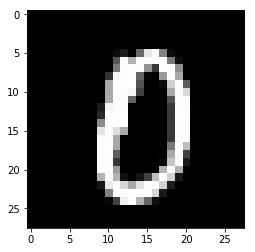

Image with label:  4


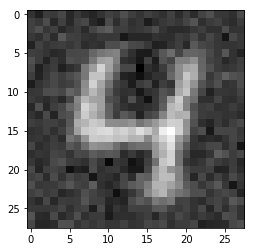

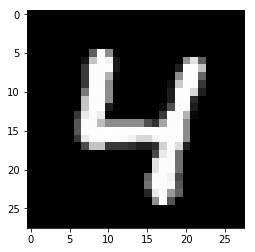

Image with label:  1


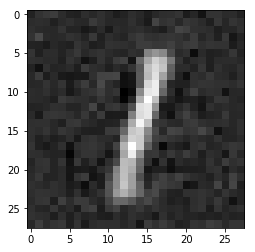

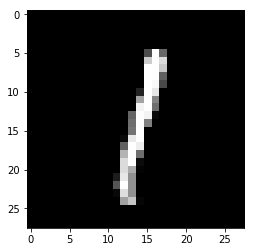

Image with label:  9


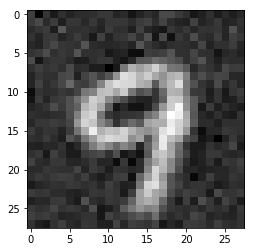

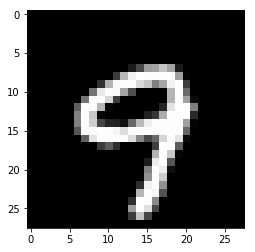

Image with label:  5


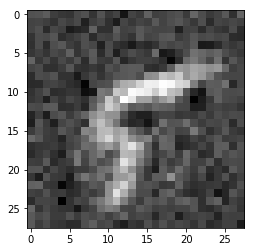

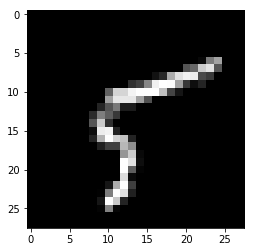

Image with label:  7


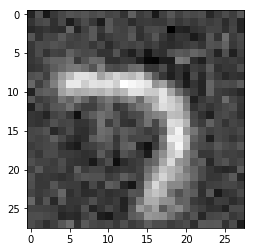

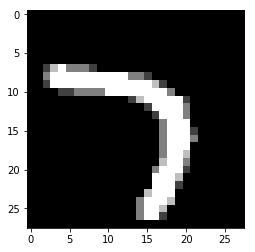

Image with label:  8


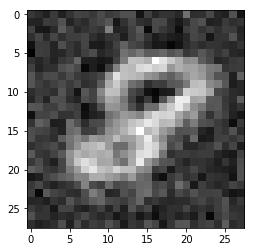

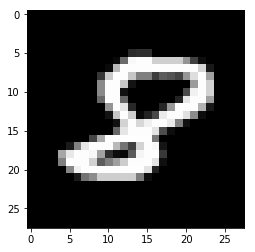

Image with label:  9


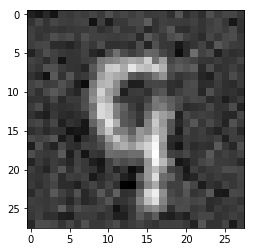

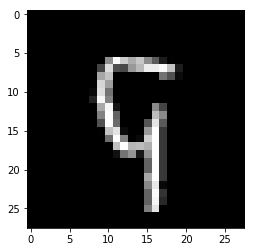

Image with label:  3


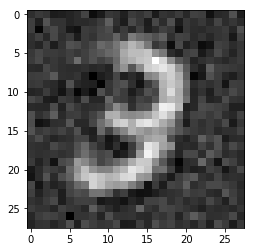

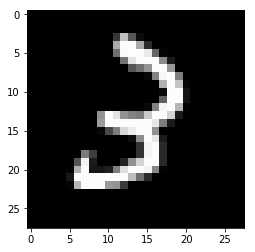

Image with label:  7


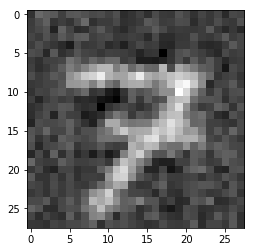

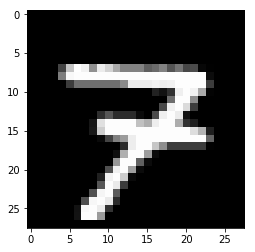

Image with label:  4


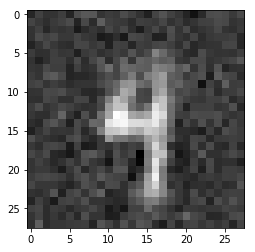

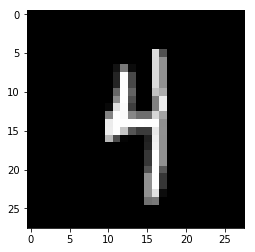

Image with label:  6


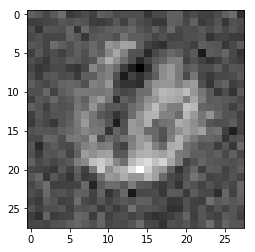

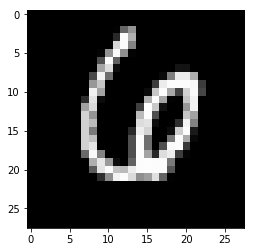

Image with label:  4


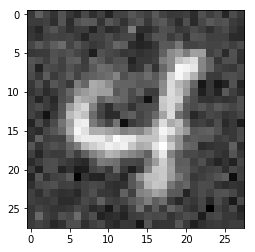

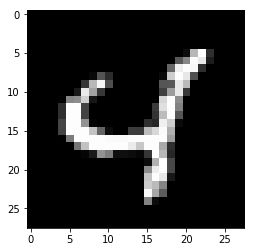

Image with label:  3


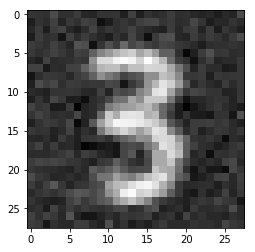

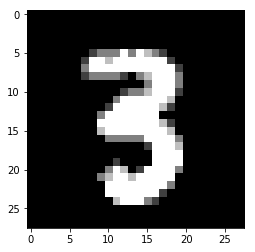

Image with label:  0


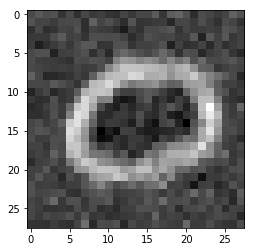

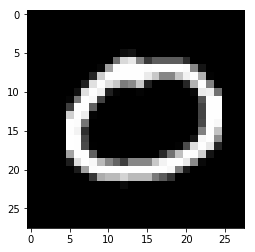

Image with label:  7


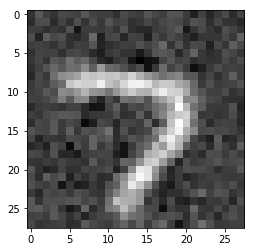

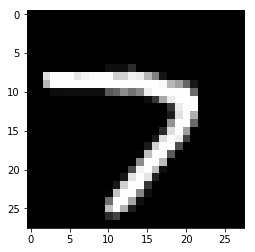

Image with label:  0


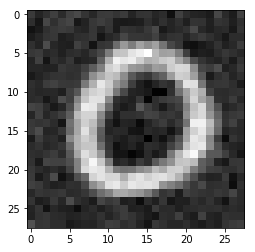

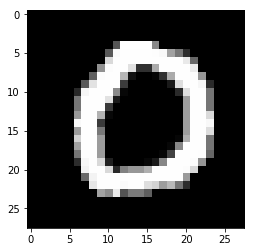

Image with label:  2


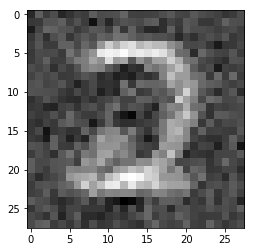

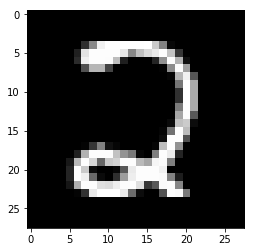

Image with label:  9


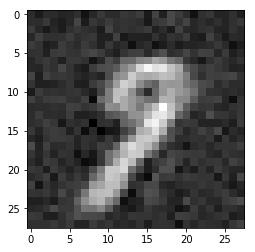

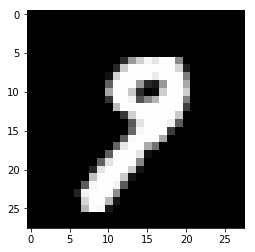

Image with label:  1


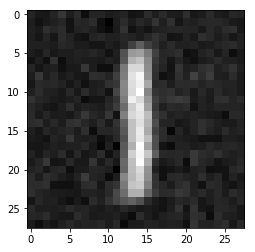

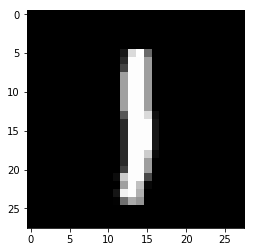

Image with label:  7


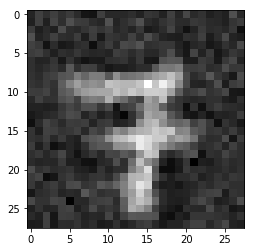

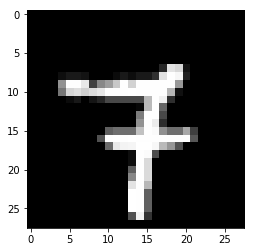

Image with label:  3


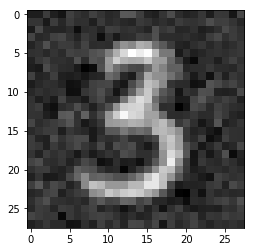

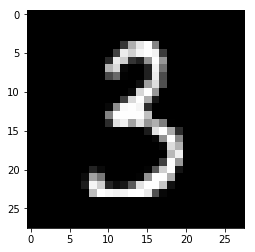

Image with label:  2


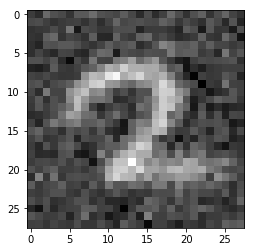

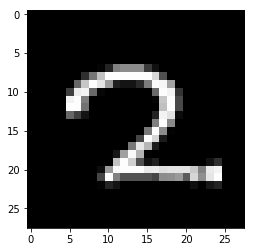

Image with label:  9


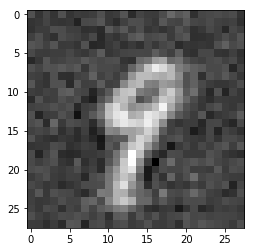

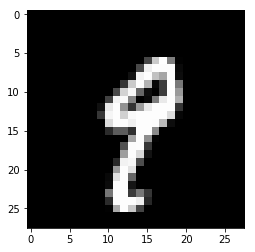

Image with label:  7


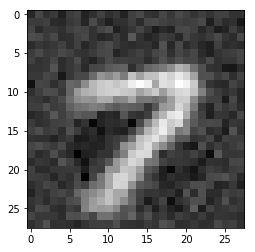

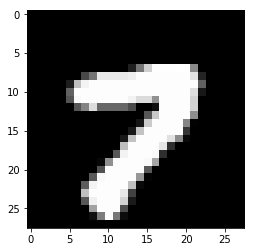

Image with label:  7


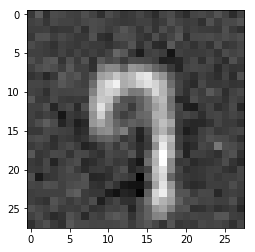

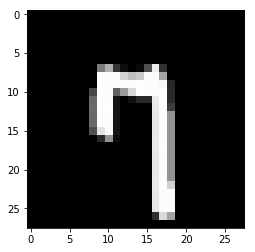

Image with label:  6


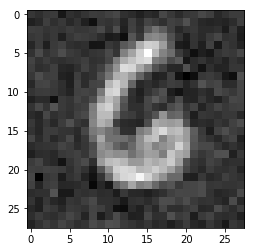

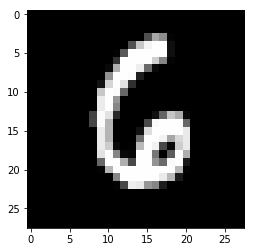

Image with label:  2


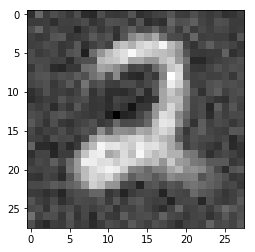

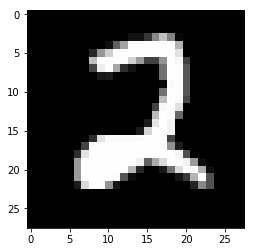

Image with label:  7


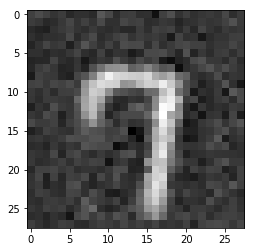

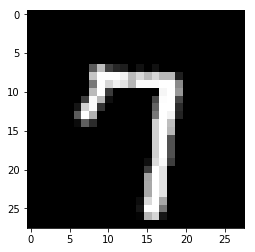

Image with label:  8


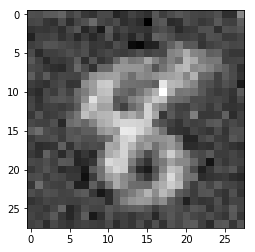

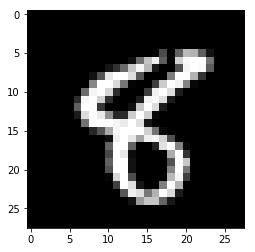

Image with label:  4


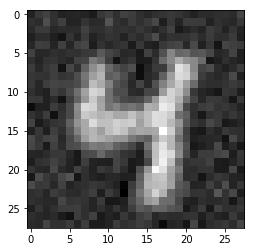

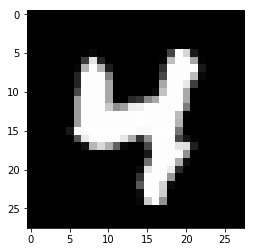

Image with label:  7


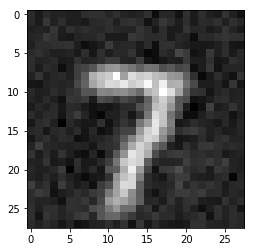

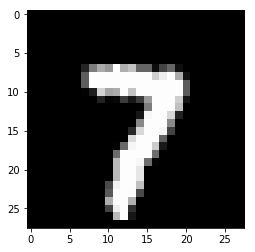

Image with label:  3


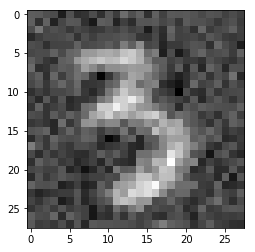

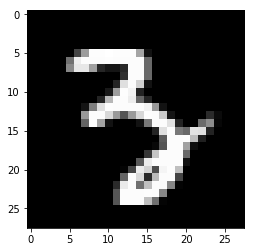

Image with label:  6


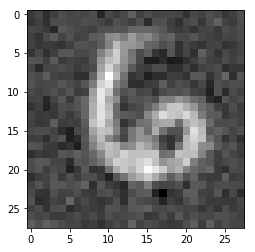

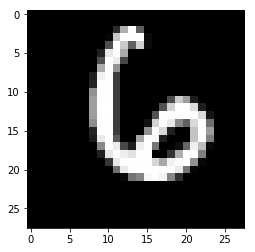

Image with label:  1


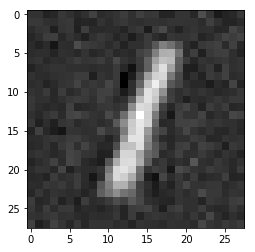

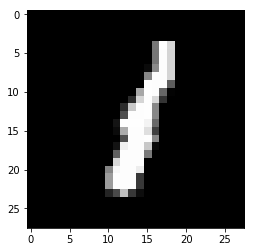

Image with label:  3


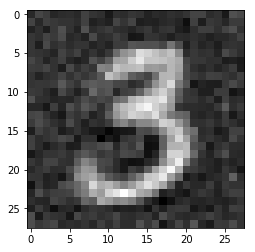

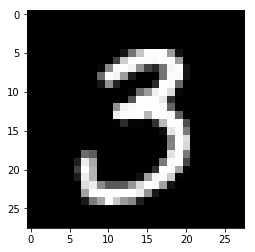

Image with label:  6


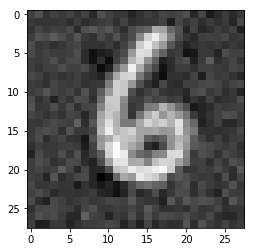

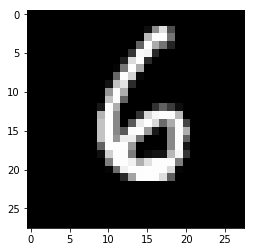

Image with label:  9


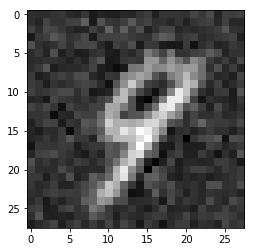

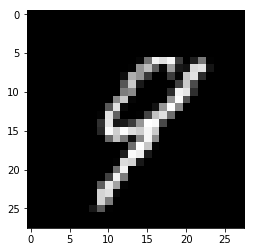

Image with label:  3


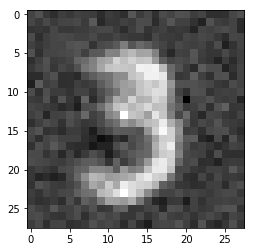

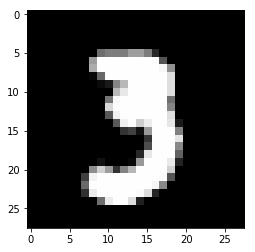

Image with label:  1


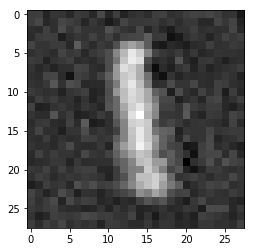

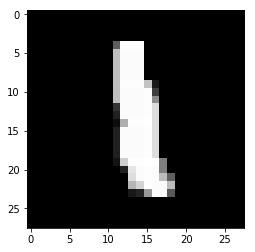

Image with label:  4


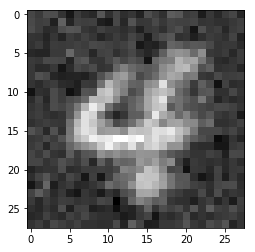

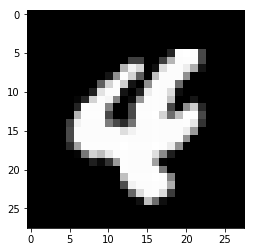

Image with label:  1


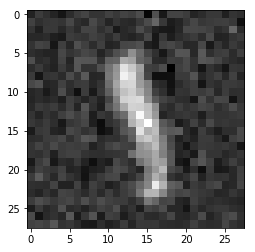

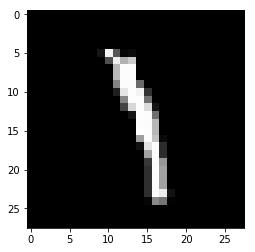

Image with label:  7


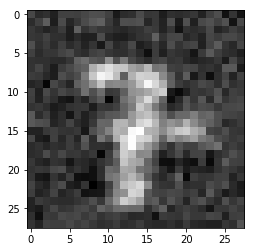

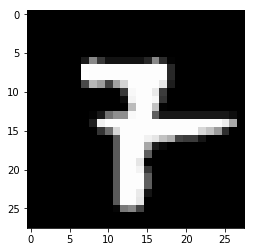

Image with label:  6


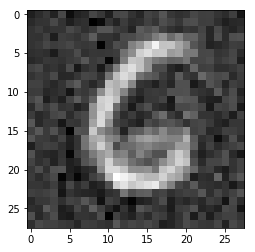

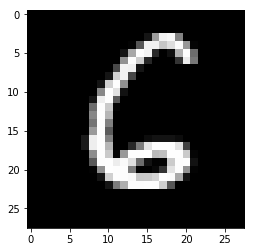

Image with label:  9


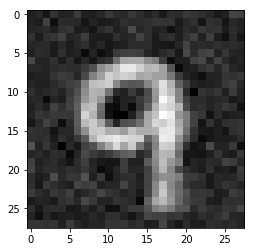

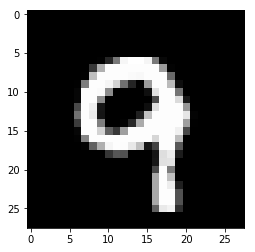

(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)
(100, 512)

In [18]:
### Visualize the results of the second DNN: looks good

# Again we wanted to visualize the performance of the decoder. The re-generated images (+ the original images) 
# are plotted from the first batch of the test set. 

test_iter = chainer.iterators.SerialIterator(testset, batchsize, repeat=False, shuffle=False)

first_batch = True

for j, batch in enumerate(test_iter):
    with chainer.using_config('train', False):
        images, labels = concat_examples(batch)
        features = model_encode(images, True)
        print(features.shape)
        preds = model_decode(features)
        if first_batch:
            for input_ in (range(preds.shape[0])):
                image = images[input_]
                label = labels[input_]
                pred_ = preds[input_].data
                print("Image with label: ", label)
                plt.imshow(pred_.reshape(28, 28), cmap='gray')
                plt.show()
                plt.imshow(image.reshape(28, 28), cmap='gray')
                plt.show()
        first_batch = False

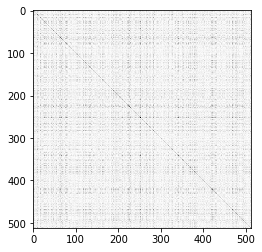

In [19]:
### Repeat task 3 but now using the two DNNs: part 1

# Specify lambda and number of pixels
lambda_ = 1e-6
numPixels = X_training.shape[1]


# Make identity matrix 
I =  np.identity(512) # Because feature_activation has 512 elements
Sigma_likelihood = 1e-3 * np.identity(Y.shape[1])

feature = model_encode(X_training.astype('float32'), True)
reconstructions = model_decode(feature).data

# Compute B: use feature activate instead of actual stimulus
B_temp = feature.T @ feature
B_temp = B_temp + lambda_ * I
B_temp = np.linalg.inv(B_temp.data) 
B = B_temp@ feature.T @ Y_training
B = B.data

#Estimate Sigma_prior: use feature activation of images in X_prior
n = X_prior.shape[0]
X_prior_features = model_encode(X_prior.astype('float32'), True)
Sigma_prior = X_prior_features.T @ X_prior_features / (n-1) 

# Add 1e-6 to Sigma prior for regularization
regularization_matrix = I * lambda_
Sigma_prior = Sigma_prior.data + regularization_matrix

# Plot Sigma_prior
plt.imshow(Sigma_prior, cmap = cm.binary)


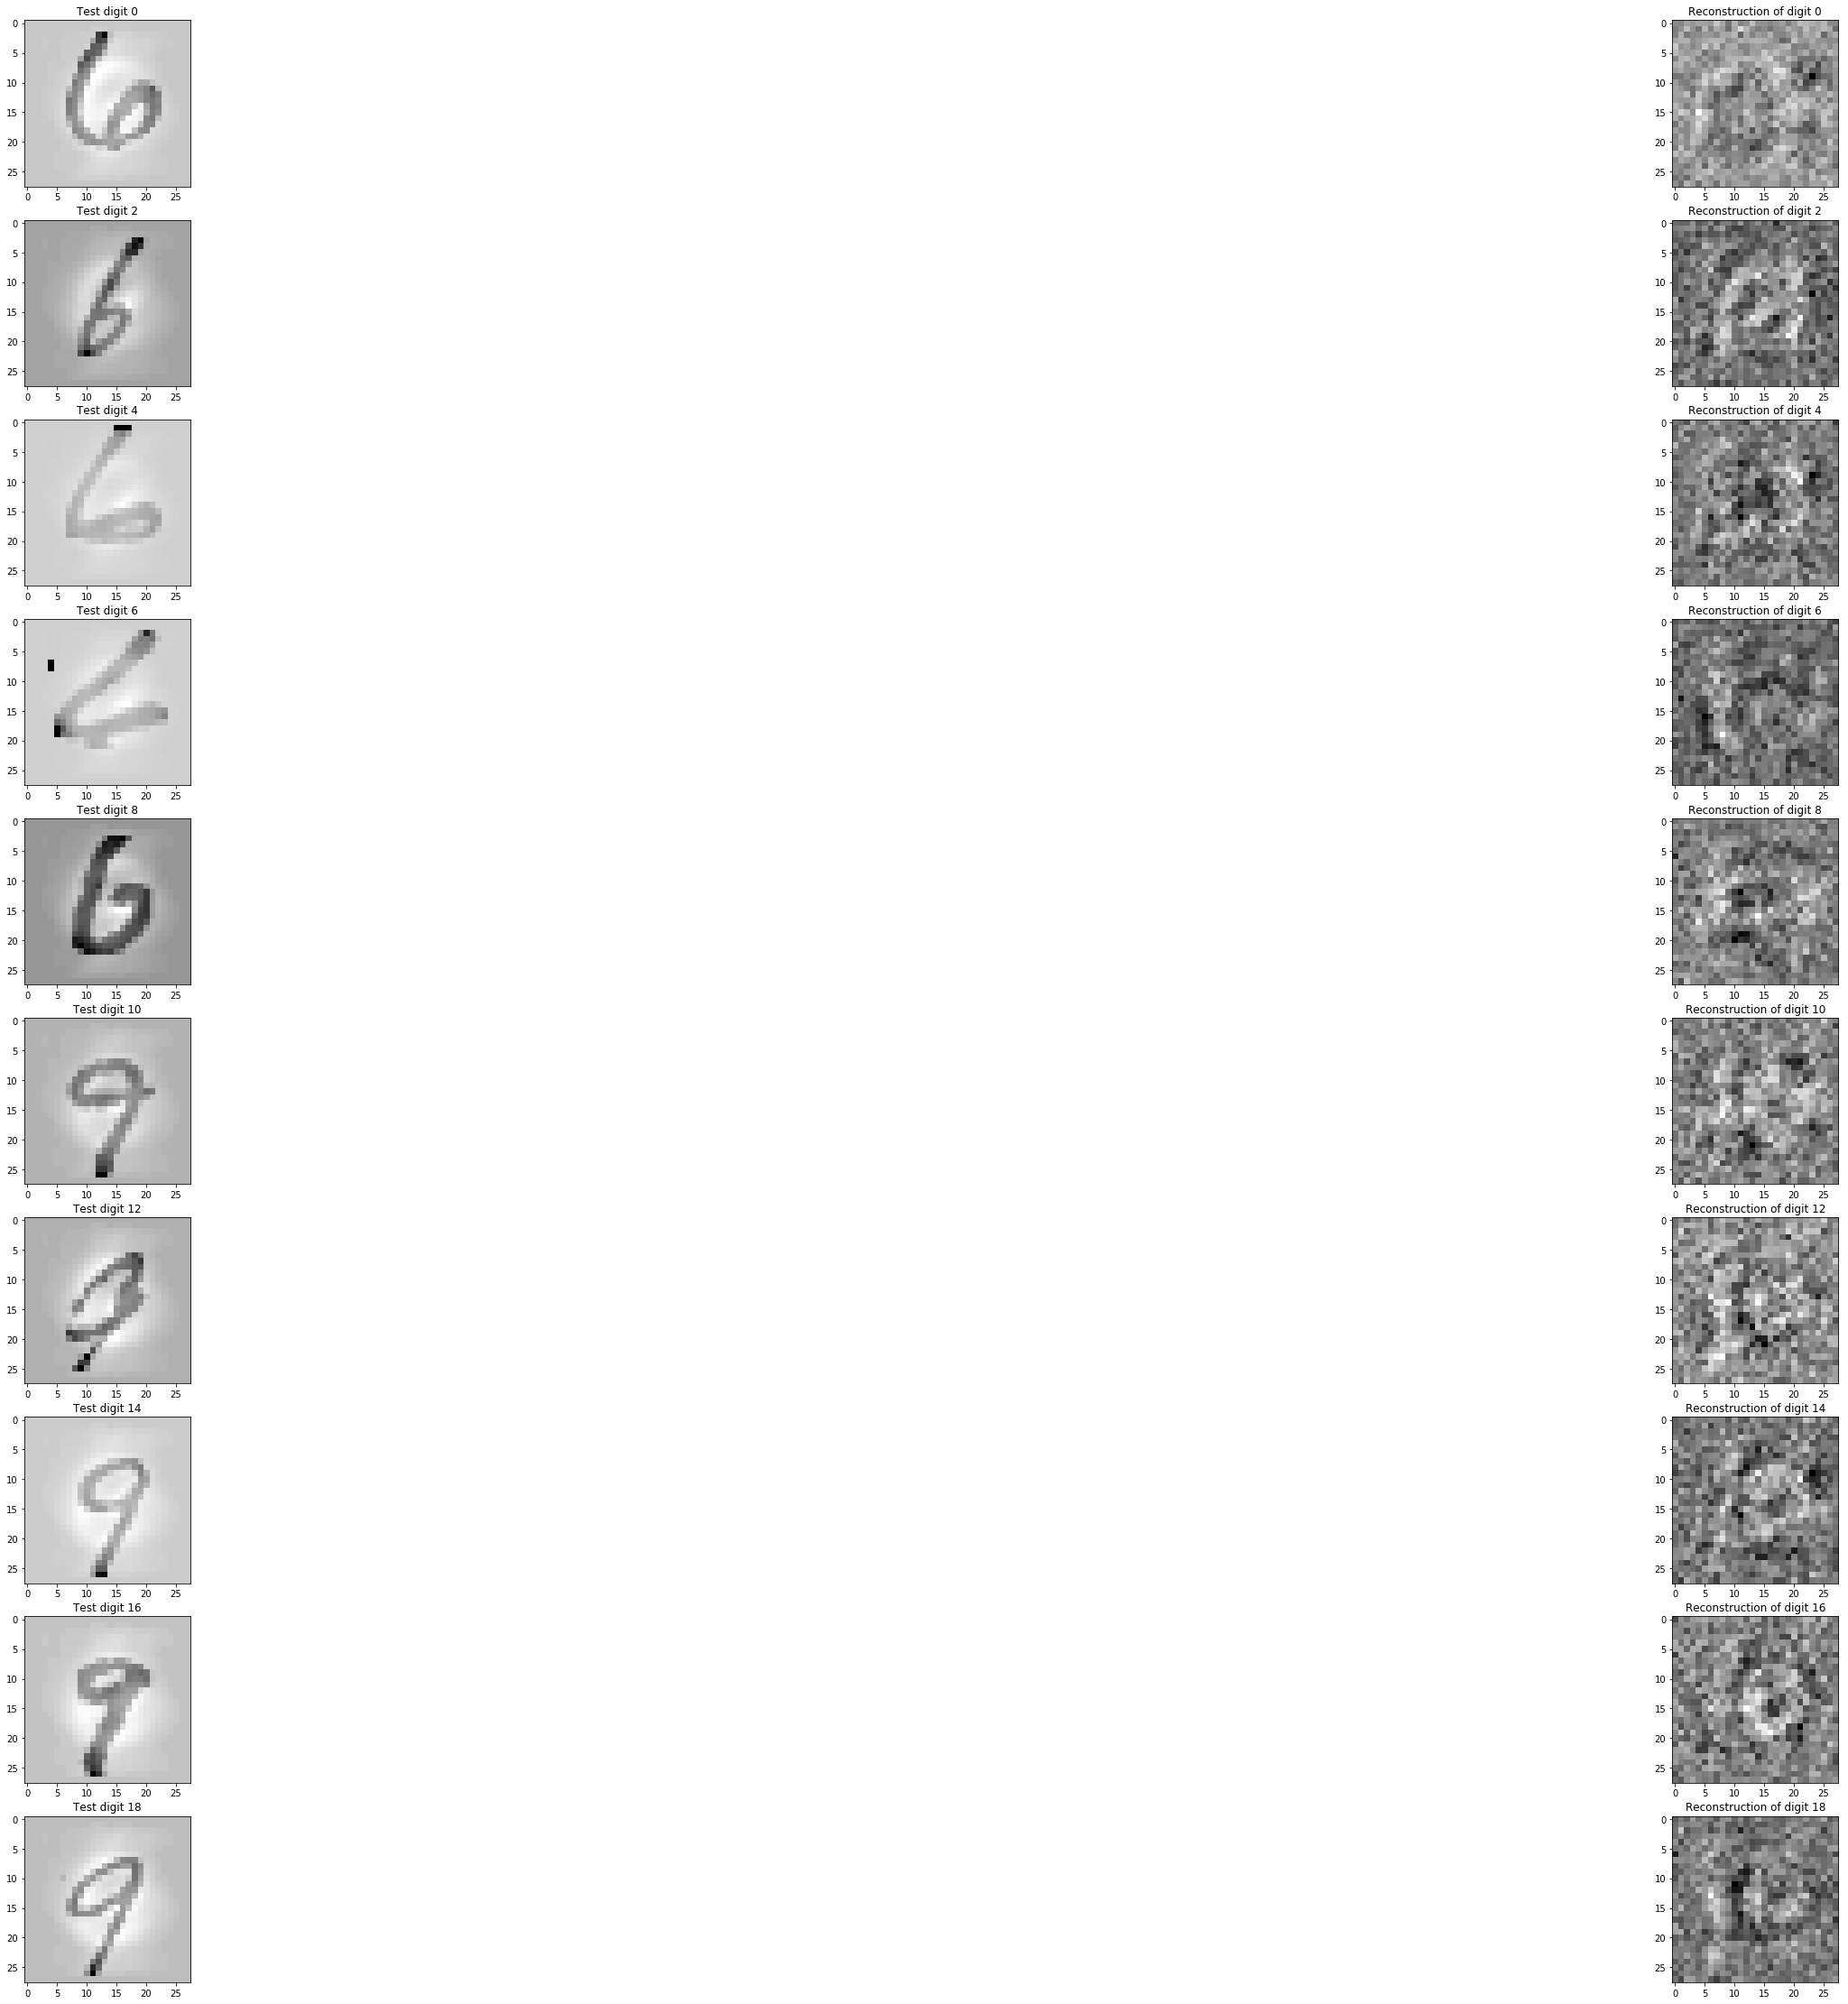

In [20]:
### Repeat task 3 but now using the two DNNs: part 2

Sigma_prior_inverse = np.linalg.inv(Sigma_prior)
Sigma_likelihood_inverse = np.linalg.inv(Sigma_likelihood)

fig, axs = plt.subplots(10,2, figsize = (60,40))
axs = axs.ravel()
for i in range(10):
    axs[2*i].imshow(X_test[i*2,:].reshape(28,28).transpose(), cmap = cm.binary)
    axs[2*i].set_title('Test digit ' + str(i*2))

    # Compute mu_posterior of feature activation
    mu_posterior_first = np.linalg.inv(Sigma_prior_inverse + B @ Sigma_likelihood_inverse @ B.T) @ B
    mu_posterior_second = Sigma_likelihood_inverse @ Y_test[i*2,:]
    mu_posterior = mu_posterior_first @ mu_posterior_second
    mu_posterior = np.expand_dims(mu_posterior, axis=0)
    
    # Compute reconstruction of mu_posterior
    reconstruction = model_decode(mu_posterior.astype('float32')).data
    
    # Store image
    axs[2*i+1].imshow(reconstruction.reshape(28,28).transpose(), cmap = cm.binary)
    axs[2*i+1].set_title('Reconstruction of digit ' + str(i*2))
plt.show()
